## Imports

In [1]:
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## MAXcut and Weighted MAXcut Hamiltonians

In [2]:
def maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * M
            else:
                ham += M
    return - 1/norm * ham    


def weighted_maxcut(nqubits, norm=2, random_graph=False):
    """Builds maxcut hamiltonian"""
    weights = jnp.array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ],
                         [0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152],
                         [0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606],
                         [0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215],
                         [0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443]], 
                        dtype=np.float64)
    if random_graph:
        aa = np.random.randint(1, nqubits*(nqubits-1)/2+1)
        graph = nx.random_graphs.dense_gnm_random_graph(nqubits, aa)
        V = nx.adjacency_matrix(graph).toarray()

    ham = jnp.zeros(shape=(2**nqubits,2**nqubits), dtype=np.float64)
    z = jnp.array([[1,0],[0,-1]], dtype=np.float64)
    iden = jnp.array([[1,0],[0,1]], dtype=np.float64)
    for i in range(nqubits):
        for j in range(nqubits):
            h = jnp.eye(1)
            for k in range(nqubits):
                if (k == i) ^ (k == j):
                    h = jnp.kron(h, z)
                else:
                    h = jnp.kron(h, iden)            
            M = jnp.eye(2**nqubits) - h
            if random_graph:
                ham += V[i,j] * weights[i,j] * M
            else:
                ham += M * weights[i,j]
    return - 1/norm * ham    

## Optimization class

In [3]:
def Qu(beta, eps=1e-3, deltal=1):
    return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


class FragmentedQuITE:
    
    def __init__(self, nqubits, hamiltonian, query, eps=1e-3):
        """Test function for optimization."""
        self.n = nqubits
        energy = jnp.linalg.eigvalsh(hamiltonian)
        self.E = energy/((np.max(energy)-np.min(energy))/2)
        self.Emin = np.min(self.E)
        self.query = query
        self.eps = eps

    def minimize(self, schedule, r, b, initial_parameters=None, method='BFGS', bounds=None, options=None):
        """Optimizes scheduling function."""
        from scipy.optimize import minimize
        
        # imposes differences to be positive
        def derivative(p):
            points = np.array([schedule(step/r, p) for step in range(1, r+1)])
            return np.diff(points)
                        
        con1 = None
        if method == 'COBYLA':
            con1 = {'type': 'ineq', 'fun': derivative}        
        m = minimize(lambda p, _: self.compute_query(p, schedule, r, b),
                        initial_parameters,
                        method, bounds=bounds, options=options, constraints=con1)
        return m      
        
    def compute_query(self, params, schedule, r, b):
        """Compute query optimization."""
        beta = np.array([ b * schedule(step/r, params) for step in range(1, r+1)])
        
        # k == 0
        PsucBr = self.Psuc(beta[r-1])
        eps_prime = self.eps / (2 * 4.0**(r-1)) * np.sqrt(PsucBr)
        Sigma = self.query(beta[0]-0, eps=eps_prime, deltal=1)

        # k > 0
        DeltaBeta = np.diff(beta)
        for k in range(r-1):
            PsucBk = self.Psuc(beta[k])
            eps_prime = self.eps / 4.0**(r-(k+1)) * np.sqrt(PsucBr/PsucBk)
            Sigma += PsucBk * self.query(DeltaBeta[k], eps=eps_prime, deltal=1)
        
        Psbeta = self.Psuc(beta[r-1])        
        return 1/Psbeta * Sigma

    def Psuc(self, beta):
        Zt =  np.sum(np.exp(-beta * (self.E - self.Emin)))
        N = 2**self.n    
        return Zt / N
    
    def Qfrac_linear(self, r, b):
        """Return linear query prediction."""
        return self.compute_query(params=None, schedule=lambda t, _: t, r=r, b=b)
    
    def Q(self, beta, alpha=1):        
        Psbeta = self.Psuc(beta)
        bquery = self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)
        return 1/Psbeta * bquery
    
    def Qampl(self, beta, alpha=1):
        Psbeta = self.Psuc(beta)                
        return 1/np.sqrt(Psbeta) * self.query(beta=beta**alpha, eps=self.eps / 2 * np.sqrt(Psbeta), deltal=1)

## Example

In [7]:
# setup
np.random.seed(0)
ntrials = 10
nqubits = 5
npol = 1

def myschedule(t, params):
    return t**params[0]


r_range = range(2, 25) 
beta_max = 300
alpha_c = 0.6
alpha_ampl = 0.85
beta_range = range(2, beta_max+1, 10)
qref = np.zeros(shape=(len(beta_range),ntrials))
qampl = np.zeros(shape=(len(beta_range),ntrials))
qampl_alpha = np.zeros(shape=(len(beta_range),ntrials))
qc = np.zeros(shape=(len(beta_range),ntrials))
qc_alpha = np.zeros(shape=(len(beta_range),ntrials))
bestr = np.zeros(shape=(len(beta_range), ntrials))
bestr_opt = np.zeros(shape=(len(beta_range), ntrials))
qopt = np.zeros(shape=(len(beta_range),ntrials))
parameters = np.zeros(shape=(len(beta_range), ntrials, npol))


for nt in range(ntrials):
    print(f'trial={nt}')
    model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                            random_graph=True), Qu)
    
    for ii, beta in enumerate(beta_range):
        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')
             
        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

trial=0
trial=0, beta=2, r=2, reference=24.331269102689365
trial=0, beta=2, r=3, reference=28.964268252497188
trial=0, beta=2, r=4, reference=34.23738564048051
trial=0, beta=2, r=5, reference=39.94167355687318
trial=0, beta=2, r=6, reference=46.016528545498694
trial=0, beta=2, r=7, reference=52.43800601623529
trial=0, beta=2, r=8, reference=59.19413624980082
trial=0, beta=2, r=9, reference=66.27763647102181
trial=0, beta=2, r=10, reference=73.68332832755021
trial=0, beta=2, r=11, reference=81.40709751756116
trial=0, beta=2, r=12, reference=89.44543150368028
trial=0, beta=2, r=13, reference=97.79519672874298
trial=0, beta=2, r=14, reference=106.45352313437868
trial=0, beta=2, r=15, reference=115.4177399350799
trial=0, beta=2, r=16, reference=124.68533726234953
trial=0, beta=2, r=17, reference=134.2539415365291
trial=0, beta=2, r=18, reference=144.1212984829083
trial=0, beta=2, r=19, reference=154.28526061787224
trial=0, beta=2, r=20, reference=164.74377748626858
trial=0, beta=2, r=21, r

trial=0, beta=22, r=15, opt result=346.7420183771439, param=[0.88085984] success=True
trial=0, beta=22, r=16, opt result=361.56930431341704, param=[0.84880435] success=True
trial=0, beta=22, r=17, opt result=376.5065108715032, param=[0.81983071] success=True
trial=0, beta=22, r=18, opt result=391.5574570259113, param=[0.79346723] success=True
trial=0, beta=22, r=19, opt result=406.72560436127685, param=[0.76933558] success=True
trial=0, beta=22, r=20, opt result=422.0140112801658, param=[0.74712855] success=True
trial=0, beta=22, r=21, opt result=437.4253356955644, param=[0.72659407] success=True
trial=0, beta=22, r=22, opt result=452.9618607380418, param=[0.70752324] success=True
trial=0, beta=22, r=23, opt result=468.6255299002694, param=[0.68974144] success=True
trial=0, beta=22, r=24, opt result=484.4179845081338, param=[0.67310166] success=True
trial=0, beta=32, r=2, reference=396.78640244181565
trial=0, beta=32, r=3, reference=335.34925430539255
trial=0, beta=32, r=4, reference=3

trial=0, beta=52, r=5, opt result=325.61769239172986, param=[2.11123506] success=True
trial=0, beta=52, r=6, opt result=339.3691818054343, param=[1.94825083] success=True
trial=0, beta=52, r=7, opt result=355.4786739594952, param=[1.81283327] success=True
trial=0, beta=52, r=8, opt result=372.90522154427356, param=[1.69901856] success=True
trial=0, beta=52, r=9, opt result=439.08026528814344, param=[12.3403629] success=True
trial=0, beta=52, r=10, opt result=409.83027781568074, param=[1.52039437] success=True
trial=0, beta=52, r=11, opt result=428.8757004413173, param=[1.44943128] success=True
trial=0, beta=52, r=12, opt result=448.15902071555524, param=[1.38761492] success=True
trial=0, beta=52, r=13, opt result=467.6237502558867, param=[1.33325639] success=True
trial=0, beta=52, r=14, opt result=487.23697205059597, param=[1.28504001] success=True
trial=0, beta=52, r=15, opt result=506.98020334334365, param=[1.24193443] success=True
trial=0, beta=52, r=16, opt result=526.8439237723514

<ipython-input-3-99f2315b6c82>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=72, r=6, opt result=403.21241467555103, param=[2.09818368] success=True
trial=0, beta=72, r=7, opt result=419.77088763203847, param=[1.96301368] success=True
trial=0, beta=72, r=8, opt result=438.2113611785657, param=[1.84821622] success=True
trial=0, beta=72, r=9, opt result=513.4468692999042, param=[10.37672083] success=True
trial=0, beta=72, r=10, opt result=531.7540163492591, param=[14.20865711] success=True
trial=0, beta=72, r=11, opt result=547.6868338437947, param=[17.11095304] success=True
trial=0, beta=72, r=12, opt result=562.1332728007444, param=[20.00302266] success=True
trial=0, beta=72, r=13, opt result=575.3884919969845, param=[23.03681251] success=True
trial=0, beta=72, r=14, opt result=587.6291134139682, param=[26.26421823] success=True
trial=0, beta=72, r=15, opt result=599.0022666470246, param=[29.62773506] success=True
trial=0, beta=72, r=16, opt result=609.6673538451196, param=[32.96971504] success=True


<ipython-input-3-99f2315b6c82>:2: RuntimeWarning: overflow encountered in double_scalars
  return np.e*beta*deltal/2.0 + np.log(1.0/eps) / np.log(np.e + 2.0*np.log(1.0/eps)/(beta*np.e*deltal))


trial=0, beta=72, r=17, opt result=619.7805990204151, param=[36.19697239] success=True
trial=0, beta=72, r=18, opt result=629.4617846481891, param=[39.31757628] success=True
trial=0, beta=72, r=19, opt result=674.5971052501817, param=[1.2305377] success=True
trial=0, beta=72, r=20, opt result=647.8302106322617, param=[45.36759688] success=True
trial=0, beta=72, r=21, opt result=656.6148728746174, param=[48.34209062] success=True
trial=0, beta=72, r=22, opt result=665.1778628554054, param=[51.30040379] success=True
trial=0, beta=72, r=23, opt result=673.5436822734955, param=[54.25021076] success=True
trial=0, beta=72, r=24, opt result=681.7322380687295, param=[57.19659086] success=True
trial=0, beta=82, r=2, reference=1054.9948292183046
trial=0, beta=82, r=3, reference=824.5191724751496
trial=0, beta=82, r=4, reference=721.0182943751339
trial=0, beta=82, r=5, reference=667.7586073227978
trial=0, beta=82, r=6, reference=639.3238683671179
trial=0, beta=82, r=7, reference=624.9089159458116

trial=0, beta=102, r=4, opt result=462.7176927504178, param=[2.63298163] success=True
trial=0, beta=102, r=5, opt result=466.34919165308935, param=[2.41511407] success=True
trial=0, beta=102, r=6, opt result=478.2659891272254, param=[2.25139839] success=True
trial=0, beta=102, r=7, opt result=494.522036923475, param=[2.11659995] success=True
trial=0, beta=102, r=8, opt result=513.3379542432544, param=[2.0015193] success=True
trial=0, beta=102, r=9, opt result=533.7808272784092, param=[1.90207709] success=True
trial=0, beta=102, r=10, opt result=617.425668540089, param=[11.83206806] success=True
trial=0, beta=102, r=11, opt result=636.6664152280707, param=[15.31216674] success=True
trial=0, beta=102, r=12, opt result=653.4914279938126, param=[18.32952024] success=True
trial=0, beta=102, r=13, opt result=668.8398626387052, param=[21.1223291] success=True
trial=0, beta=102, r=14, opt result=683.090555821837, param=[23.89457446] success=True
trial=0, beta=102, r=15, opt result=696.43876014

trial=0, beta=122, r=24, opt result=846.5156329148847, param=[55.13359906] success=True
trial=0, beta=132, r=2, reference=1681.163071941592
trial=0, beta=132, r=3, reference=1272.6042028294278
trial=0, beta=132, r=4, reference=1082.637624818787
trial=0, beta=132, r=5, reference=979.3552599649109
trial=0, beta=132, r=6, reference=919.018850298123
trial=0, beta=132, r=7, reference=882.9712434821352
trial=0, beta=132, r=8, reference=861.9342022728529
trial=0, beta=132, r=9, reference=850.791592069799
trial=0, beta=132, r=10, reference=846.5060478844839
trial=0, beta=132, r=11, reference=847.1717664343628
trial=0, beta=132, r=12, reference=851.540228951171
trial=0, beta=132, r=13, reference=858.7644814910639
trial=0, beta=132, r=14, reference=868.25301190596
trial=0, beta=132, r=15, reference=879.58227686842
trial=0, beta=132, r=16, reference=892.4423091674917
trial=0, beta=132, r=17, reference=906.6018054184213
trial=0, beta=132, r=18, reference=921.8851049711675
trial=0, beta=132, r=19, 

trial=0, beta=152, r=9, opt result=626.9208733178034, param=[2.07067375] success=True
trial=0, beta=152, r=10, opt result=648.9090326285979, param=[1.98281029] success=True
trial=0, beta=152, r=11, opt result=671.97205234754, param=[1.9053254] success=True
trial=0, beta=152, r=12, opt result=756.628043338072, param=[15.85957479] success=True
trial=0, beta=152, r=13, opt result=774.6623866449526, param=[18.62051281] success=True
trial=0, beta=152, r=14, opt result=791.1886765749364, param=[21.40872812] success=True
trial=0, beta=152, r=15, opt result=806.5397574185548, param=[24.14194806] success=True
trial=0, beta=152, r=16, opt result=820.9684966657018, param=[26.82334379] success=True
trial=0, beta=152, r=17, opt result=834.6455513225832, param=[29.48556889] success=True
trial=0, beta=152, r=18, opt result=847.6874077654187, param=[32.15544159] success=True
trial=0, beta=152, r=19, opt result=860.1777522707755, param=[34.85219861] success=True
trial=0, beta=152, r=20, opt result=872.

trial=0, beta=182, r=4, opt result=617.5510037478077, param=[2.90744888] success=True
trial=0, beta=182, r=5, opt result=614.0694400810318, param=[2.66948427] success=True
trial=0, beta=182, r=6, opt result=622.2531304034799, param=[2.49751436] success=True
trial=0, beta=182, r=7, opt result=636.5261941398377, param=[2.3608626] success=True
trial=0, beta=182, r=8, opt result=654.4419123049543, param=[2.24543447] success=True
trial=0, beta=182, r=9, opt result=674.7452870164869, param=[2.14504471] success=True
trial=0, beta=182, r=10, opt result=696.7120003529329, param=[2.05675113] success=True
trial=0, beta=182, r=11, opt result=784.675940116127, param=[12.64360786] success=True
trial=0, beta=182, r=12, opt result=805.3552346309838, param=[15.31355886] success=True
trial=0, beta=182, r=13, opt result=824.1795392813727, param=[17.83653846] success=True
trial=0, beta=182, r=14, opt result=841.5604272243006, param=[20.40649775] success=True
trial=0, beta=182, r=15, opt result=857.7460587

trial=0, beta=202, r=24, opt result=1007.1399524354013, param=[45.8484509] success=True
trial=0, beta=212, r=2, reference=2621.2472668875375
trial=0, beta=212, r=3, reference=1936.0501579081522
trial=0, beta=212, r=4, reference=1609.9218843243923
trial=0, beta=212, r=5, reference=1426.6521730723045
trial=0, beta=212, r=6, reference=1314.4071512075989
trial=0, beta=212, r=7, reference=1242.4908815598048
trial=0, beta=212, r=8, reference=1195.5953930021815
trial=0, beta=212, r=9, reference=1165.240627612062
trial=0, beta=212, r=10, reference=1146.357598398081
trial=0, beta=212, r=11, reference=1135.7373538772667
trial=0, beta=212, r=12, reference=1131.2558686247703
trial=0, beta=212, r=13, reference=1131.4565298239945
trial=0, beta=212, r=14, reference=1135.311272968079
trial=0, beta=212, r=15, reference=1142.0770052336352
trial=0, beta=212, r=16, reference=1151.2056934944346
trial=0, beta=212, r=17, reference=1162.2860940547273
trial=0, beta=212, r=18, reference=1175.0048815889893
trial

trial=0, beta=232, r=7, opt result=712.9243877527664, param=[2.46004416] success=True
trial=0, beta=232, r=8, opt result=730.1648068770864, param=[2.344028] success=True
trial=0, beta=232, r=9, opt result=750.0883665868723, param=[2.24342883] success=True
trial=0, beta=232, r=10, opt result=771.9030422389731, param=[2.15473186] success=True
trial=0, beta=232, r=11, opt result=858.2448330963567, param=[11.99748646] success=True
trial=0, beta=232, r=12, opt result=879.5149550480546, param=[14.97309239] success=True
trial=0, beta=232, r=13, opt result=898.8119427996741, param=[17.39894419] success=True
trial=0, beta=232, r=14, opt result=916.7496185172078, param=[19.76730172] success=True
trial=0, beta=232, r=15, opt result=933.5806473386415, param=[22.15960943] success=True
trial=0, beta=232, r=16, opt result=949.4716442650397, param=[24.59444791] success=True
trial=0, beta=232, r=17, opt result=964.5524308676386, param=[27.06810261] success=True
trial=0, beta=232, r=18, opt result=978.9

trial=0, beta=262, r=9, reference=1351.977867092424
trial=0, beta=262, r=10, reference=1323.4548990718545
trial=0, beta=262, r=11, reference=1305.31258171341
trial=0, beta=262, r=12, reference=1294.8896365977648
trial=0, beta=262, r=13, reference=1290.3539943638827
trial=0, beta=262, r=14, reference=1290.4068258981586
trial=0, beta=262, r=15, reference=1294.1047218716635
trial=0, beta=262, r=16, reference=1300.7483473030975
trial=0, beta=262, r=17, reference=1309.8102390615397
trial=0, beta=262, r=18, reference=1320.8865684193493
trial=0, beta=262, r=19, reference=1333.6640794206517
trial=0, beta=262, r=20, reference=1347.8969237102733
trial=0, beta=262, r=21, reference=1363.3901167883869
trial=0, beta=262, r=22, reference=1379.9875251181113
trial=0, beta=262, r=23, reference=1397.563015261235
trial=0, beta=262, r=24, reference=1416.0138483100482
trial=0, beta=262, r=2, opt result=1007.1636239522679, param=[4.61554605] success=True
trial=0, beta=262, r=3, opt result=1036.9497260194212,

trial=0, beta=282, r=13, opt result=969.8742102337859, param=[17.36358877] success=True
trial=0, beta=282, r=14, opt result=987.8809308708086, param=[19.68240195] success=True
trial=0, beta=282, r=15, opt result=1004.8411626219222, param=[21.98435479] success=True
trial=0, beta=282, r=16, opt result=1020.9210782957181, param=[24.30588082] success=True
trial=0, beta=282, r=17, opt result=1036.240558271664, param=[26.65831909] success=True
trial=0, beta=282, r=18, opt result=1050.8944537075822, param=[29.04282554] success=True
trial=0, beta=282, r=19, opt result=1064.9615113633054, param=[31.45568224] success=True
trial=0, beta=282, r=20, opt result=1078.50870795434, param=[33.89132739] success=True
trial=0, beta=282, r=21, opt result=1091.5935205866979, param=[36.3447084] success=True
trial=0, beta=282, r=22, opt result=1104.2653051261516, param=[38.81227543] success=True
trial=0, beta=282, r=23, opt result=1116.5663607202057, param=[41.2916614] success=True
trial=0, beta=282, r=24, opt

trial=1, beta=12, r=3, opt result=39.43651512309348, param=[5.72524728] success=True
trial=1, beta=12, r=4, opt result=42.022300690358875, param=[8.31389902] success=True
trial=1, beta=12, r=5, opt result=44.14979597918432, param=[11.0520948] success=True
trial=1, beta=12, r=6, opt result=45.99239139059175, param=[13.90912494] success=True
trial=1, beta=12, r=7, opt result=47.63582464245355, param=[16.86891794] success=True
trial=1, beta=12, r=8, opt result=49.1309720382859, param=[19.92313702] success=True
trial=1, beta=12, r=9, opt result=50.510802501898205, param=[23.06755287] success=True
trial=1, beta=12, r=10, opt result=51.79794594281522, param=[26.30043278] success=True
trial=1, beta=12, r=11, opt result=53.00860411215416, param=[29.62176673] success=True
trial=1, beta=12, r=12, opt result=54.15475871403882, param=[33.03306375] success=True
trial=1, beta=12, r=13, opt result=55.24549894999377, param=[36.53719732] success=True
trial=1, beta=12, r=14, opt result=48.08407103926137

trial=1, beta=42, r=18, reference=234.35373222353024
trial=1, beta=42, r=19, reference=244.35669911170683
trial=1, beta=42, r=20, reference=254.53406127478124
trial=1, beta=42, r=21, reference=264.8875989301117
trial=1, beta=42, r=22, reference=275.41879857710774
trial=1, beta=42, r=23, reference=286.1288760183292
trial=1, beta=42, r=24, reference=297.018803979599
trial=1, beta=42, r=2, opt result=79.04888870993508, param=[4.4888952] success=True
trial=1, beta=42, r=3, opt result=82.54374114578565, param=[7.79763471] success=True
trial=1, beta=42, r=4, opt result=84.78198788013944, param=[11.05825057] success=True
trial=1, beta=42, r=5, opt result=86.58842952572557, param=[14.33985025] success=True
trial=1, beta=42, r=6, opt result=88.15641135345649, param=[17.65052114] success=True
trial=1, beta=42, r=7, opt result=89.56610527405513, param=[20.98943579] success=True
trial=1, beta=42, r=8, opt result=90.86102593916985, param=[24.35447403] success=True
trial=1, beta=42, r=9, opt result=

trial=1, beta=62, r=19, opt result=128.41892993008025, param=[66.73809927] success=True
trial=1, beta=62, r=20, opt result=129.20187631785436, param=[70.48886631] success=True
trial=1, beta=62, r=21, opt result=129.970993175699, param=[74.24990452] success=True
trial=1, beta=62, r=22, opt result=130.72750827457634, param=[78.02135778] success=True
trial=1, beta=62, r=23, opt result=131.4724874542494, param=[81.80262308] success=True
trial=1, beta=62, r=24, opt result=132.20686201069705, param=[85.59374694] success=True
trial=1, beta=72, r=2, reference=172.09000716759292
trial=1, beta=72, r=3, reference=166.1060721432922
trial=1, beta=72, r=4, reference=168.6004237403953
trial=1, beta=72, r=5, reference=174.57503132511792
trial=1, beta=72, r=6, reference=182.32520607258488
trial=1, beta=72, r=7, reference=191.10397828078925
trial=1, beta=72, r=8, reference=200.53352983205164
trial=1, beta=72, r=9, reference=210.40557115661866
trial=1, beta=72, r=10, reference=220.5992414934646
trial=1, 

trial=1, beta=92, r=5, opt result=155.2649998618927, param=[16.84544248] success=True
trial=1, beta=92, r=6, opt result=156.6695646407449, param=[20.66944992] success=True
trial=1, beta=92, r=7, opt result=157.9264261547795, param=[24.50560523] success=True
trial=1, beta=92, r=8, opt result=159.07804461374099, param=[28.35428852] success=True
trial=1, beta=92, r=9, opt result=160.15023110612873, param=[32.21523134] success=True
trial=1, beta=92, r=10, opt result=161.1600731771099, param=[36.08790979] success=True
trial=1, beta=92, r=11, opt result=162.11955519748892, param=[39.97181155] success=True
trial=1, beta=92, r=12, opt result=163.03744298855855, param=[43.86640262] success=True
trial=1, beta=92, r=13, opt result=163.92035819161254, param=[47.77124059] success=True
trial=1, beta=92, r=14, opt result=164.77343291063636, param=[51.68592345] success=True
trial=1, beta=92, r=15, opt result=165.60072948266497, param=[55.61007841] success=True
trial=1, beta=92, r=16, opt result=166.40

trial=1, beta=122, r=4, opt result=200.3799373076979, param=[6.62779175] success=True
trial=1, beta=122, r=5, opt result=196.26442120918227, param=[17.79532822] success=True
trial=1, beta=122, r=6, opt result=197.61658514873787, param=[21.82293834] success=True
trial=1, beta=122, r=7, opt result=198.82405229438027, param=[25.85914758] success=True
trial=1, beta=122, r=8, opt result=199.92891094197378, param=[29.90484659] success=True
trial=1, beta=122, r=9, opt result=200.95662390759514, param=[33.96011495] success=True
trial=1, beta=122, r=10, opt result=201.9239733418731, param=[38.02468767] success=True
trial=1, beta=122, r=11, opt result=202.84268533693714, param=[42.09828719] success=True
trial=1, beta=122, r=12, opt result=203.72131031794294, param=[46.18058884] success=True
trial=1, beta=122, r=13, opt result=204.5662907754121, param=[50.27122522] success=True
trial=1, beta=122, r=14, opt result=205.3826093883027, param=[54.36994395] success=True
trial=1, beta=122, r=15, opt res

trial=1, beta=152, r=6, reference=316.59729285231066
trial=1, beta=152, r=7, reference=325.39800071963435
trial=1, beta=152, r=8, reference=335.79731065940183
trial=1, beta=152, r=9, reference=347.3206077896886
trial=1, beta=152, r=10, reference=359.6693215332311
trial=1, beta=152, r=11, reference=372.64510718626605
trial=1, beta=152, r=12, reference=386.11113456320516
trial=1, beta=152, r=13, reference=399.97056774291826
trial=1, beta=152, r=14, reference=414.1537311630316
trial=1, beta=152, r=15, reference=428.6100011576952
trial=1, beta=152, r=16, reference=443.3024382909756
trial=1, beta=152, r=17, reference=458.2041002427187
trial=1, beta=152, r=18, reference=473.29543529736503
trial=1, beta=152, r=19, reference=488.5623988342954
trial=1, beta=152, r=20, reference=503.9950695196671
trial=1, beta=152, r=21, reference=519.5866199541954
trial=1, beta=152, r=22, reference=535.3325439442012
trial=1, beta=152, r=23, reference=551.2300725493627
trial=1, beta=152, r=24, reference=567.2777

trial=1, beta=172, r=11, opt result=270.7427633736419, param=[44.78130036] success=True
trial=1, beta=172, r=12, opt result=271.57643475287904, param=[49.10554592] success=True
trial=1, beta=172, r=13, opt result=272.3778934150187, param=[53.43632777] success=True
trial=1, beta=172, r=14, opt result=273.1519592811018, param=[57.77353915] success=True
trial=1, beta=172, r=15, opt result=273.9024330459775, param=[62.11681235] success=True
trial=1, beta=172, r=16, opt result=274.63236674071464, param=[66.46613508] success=True
trial=1, beta=172, r=17, opt result=275.34424946299185, param=[70.82119619] success=True
trial=1, beta=172, r=18, opt result=276.0401385274467, param=[75.18204279] success=True
trial=1, beta=172, r=19, opt result=276.7217543291335, param=[79.54839923] success=True
trial=1, beta=172, r=20, opt result=277.3905503928314, param=[83.9200949] success=True
trial=1, beta=172, r=21, opt result=278.0477660499962, param=[88.29708106] success=True
trial=1, beta=172, r=22, opt r

trial=1, beta=202, r=4, opt result=303.88418091989206, param=[15.13393136] success=True
trial=1, beta=202, r=5, opt result=312.2387309300528, param=[9.87393231] success=True
trial=1, beta=202, r=6, opt result=306.63461070032855, param=[23.94951935] success=True
trial=1, beta=202, r=7, opt result=307.76128029979515, param=[28.36136044] success=True
trial=1, beta=202, r=8, opt result=308.7895771923718, param=[32.77874853] success=True
trial=1, beta=202, r=9, opt result=309.7443258681141, param=[37.20219029] success=True
trial=1, beta=202, r=10, opt result=320.4742016343414, param=[24.38256235] success=True
trial=1, beta=202, r=11, opt result=321.76731475297174, param=[27.6961617] success=True
trial=1, beta=202, r=12, opt result=312.30704160806255, param=[50.50918293] success=True
trial=1, beta=202, r=13, opt result=313.0891861267409, param=[54.95671477] success=True
trial=1, beta=202, r=14, opt result=313.844481375771, param=[59.41000262] success=True
trial=1, beta=202, r=15, opt result=

trial=1, beta=232, r=17, reference=598.5729116155749
trial=1, beta=232, r=18, reference=615.996521994711
trial=1, beta=232, r=19, reference=633.677778482565
trial=1, beta=232, r=20, reference=651.5907284955978
trial=1, beta=232, r=21, reference=669.714976381281
trial=1, beta=232, r=22, reference=688.0345593159379
trial=1, beta=232, r=23, reference=706.537063845295
trial=1, beta=232, r=24, reference=725.2129248339397
trial=1, beta=232, r=2, opt result=339.88315741459803, param=[6.39051454] success=True
trial=1, beta=232, r=3, opt result=342.9179821473869, param=[10.98467697] success=True
trial=1, beta=232, r=4, opt result=344.77961828469086, param=[15.51481371] success=True
trial=1, beta=232, r=5, opt result=353.18972762366417, param=[10.06494334] success=True
trial=1, beta=232, r=6, opt result=347.48401920117635, param=[24.54623306] success=True
trial=1, beta=232, r=7, opt result=348.59005720964535, param=[29.06452723] success=True
trial=1, beta=232, r=8, opt result=349.5988256677957, 

trial=1, beta=252, r=18, opt result=384.4202873920762, param=[80.21422564] success=True
trial=1, beta=252, r=19, opt result=385.0629372579269, param=[84.85393141] success=True
trial=1, beta=252, r=20, opt result=385.6934480638321, param=[89.49797338] success=True
trial=1, beta=252, r=21, opt result=386.31300482780165, param=[94.14617395] success=True
trial=1, beta=252, r=22, opt result=386.92262528569296, param=[98.79856162] success=True
trial=1, beta=252, r=23, opt result=387.52319003778825, param=[103.45472941] success=True
trial=1, beta=252, r=24, opt result=388.11546618493173, param=[108.11500014] success=True
trial=1, beta=262, r=2, reference=560.6154945612864
trial=1, beta=262, r=3, reference=513.0459269579518
trial=1, beta=262, r=4, reference=496.13598373538764
trial=1, beta=262, r=5, reference=491.9919563351679
trial=1, beta=262, r=6, reference=494.59095428357693
trial=1, beta=262, r=7, reference=501.3045380674473
trial=1, beta=262, r=8, reference=510.7807286166708
trial=1, bet

trial=1, beta=282, r=2, opt result=408.09679471547634, param=[6.61886503] success=True
trial=1, beta=282, r=3, opt result=411.08131663114483, param=[11.37038071] success=True
trial=1, beta=282, r=4, opt result=412.90371512768934, param=[16.05640102] success=True
trial=1, beta=282, r=5, opt result=421.38168991361107, param=[10.34129572] success=True
trial=1, beta=282, r=6, opt result=423.3186788516546, param=[13.18474196] success=True
trial=1, beta=282, r=7, opt result=416.6231871036715, param=[30.06583331] success=True
trial=1, beta=282, r=8, opt result=417.60545338178554, param=[34.739825] success=True
trial=1, beta=282, r=9, opt result=418.5163405237805, param=[39.41818402] success=True
trial=1, beta=282, r=10, opt result=419.37177810231805, param=[44.10121466] success=True
trial=1, beta=282, r=11, opt result=430.77251246254406, param=[27.97502576] success=True
trial=1, beta=282, r=12, opt result=432.0061153831089, param=[31.08901012] success=True
trial=1, beta=282, r=13, opt result=

trial=2, beta=12, r=20, reference=491.44572592779275
trial=2, beta=12, r=21, reference=515.9955260529572
trial=2, beta=12, r=22, reference=541.1973134823563
trial=2, beta=12, r=23, reference=567.0397932598044
trial=2, beta=12, r=24, reference=593.5130706867134
trial=2, beta=12, r=2, opt result=201.6632881393097, param=[2.37246559] success=True
trial=2, beta=12, r=3, opt result=196.07512249938173, param=[1.8848652] success=True
trial=2, beta=12, r=4, opt result=203.92969180683912, param=[1.60870278] success=True
trial=2, beta=12, r=5, opt result=215.65598743044862, param=[1.41074153] success=True
trial=2, beta=12, r=6, opt result=228.85273527801544, param=[1.26256129] success=True
trial=2, beta=12, r=7, opt result=242.69598710396448, param=[1.14870787] success=True
trial=2, beta=12, r=8, opt result=256.8632874410513, param=[1.05879396] success=True
trial=2, beta=12, r=9, opt result=271.217169398643, param=[0.9859448] success=True
trial=2, beta=12, r=10, opt result=285.6959682580225, par

trial=2, beta=32, r=22, opt result=529.3756448439633, param=[0.95925867] success=True
trial=2, beta=32, r=23, opt result=546.3352736699378, param=[0.94060934] success=True
trial=2, beta=32, r=24, opt result=563.4122762241224, param=[0.92321152] success=True
trial=2, beta=42, r=2, reference=640.2183615866688
trial=2, beta=42, r=3, reference=514.2748274058052
trial=2, beta=42, r=4, reference=458.24652252488784
trial=2, beta=42, r=5, reference=429.86976762144997
trial=2, beta=42, r=6, reference=415.2527128523993
trial=2, beta=42, r=7, reference=408.5476787527028
trial=2, beta=42, r=8, reference=406.889701976248
trial=2, beta=42, r=9, reference=408.7169487133394
trial=2, beta=42, r=10, reference=413.1053458259608
trial=2, beta=42, r=11, reference=419.4710939611427
trial=2, beta=42, r=12, reference=427.42507804038524
trial=2, beta=42, r=13, reference=436.69626473876656
trial=2, beta=42, r=14, reference=447.0888749646358
trial=2, beta=42, r=15, reference=458.45715596747107
trial=2, beta=42, 

trial=2, beta=62, r=7, opt result=342.76676500584625, param=[1.98062603] success=True
trial=2, beta=62, r=8, opt result=358.12055481907066, param=[1.86802447] success=True
trial=2, beta=62, r=9, opt result=436.9506779045964, param=[13.49211329] success=True
trial=2, beta=62, r=10, opt result=453.7502867305855, param=[16.17674752] success=True
trial=2, beta=62, r=11, opt result=469.0010675963656, param=[19.23662115] success=True
trial=2, beta=62, r=12, opt result=481.2135876784068, param=[27.8156956] success=True
trial=2, beta=62, r=13, opt result=442.85558039830687, param=[1.50460998] success=True
trial=2, beta=62, r=14, opt result=502.1547543815742, param=[33.85958116] success=True
trial=2, beta=62, r=15, opt result=512.0716895026472, param=[36.81125248] success=True
trial=2, beta=62, r=16, opt result=521.6845243690011, param=[39.75614944] success=True
trial=2, beta=62, r=17, opt result=531.0279981711965, param=[42.70271773] success=True
trial=2, beta=62, r=18, opt result=540.13063699

trial=2, beta=92, r=4, opt result=388.6638405354934, param=[4.89064173] success=True
trial=2, beta=92, r=5, opt result=366.2562670137241, param=[2.47269768] success=True
trial=2, beta=92, r=6, opt result=377.7757929638301, param=[2.29417639] success=True
trial=2, beta=92, r=7, opt result=391.8612365679845, param=[2.15607597] success=True
trial=2, beta=92, r=8, opt result=407.5169091951667, param=[2.04241006] success=True
trial=2, beta=92, r=9, opt result=481.07464507550793, param=[13.93090856] success=True
trial=2, beta=92, r=10, opt result=497.5392439974898, param=[16.4171502] success=True
trial=2, beta=92, r=11, opt result=512.8490551050407, param=[18.95023355] success=True
trial=2, beta=92, r=12, opt result=527.1452984233458, param=[21.6129888] success=True
trial=2, beta=92, r=13, opt result=540.5065816328528, param=[24.5157363] success=True
trial=2, beta=92, r=14, opt result=552.9034880835685, param=[28.19766759] success=True
trial=2, beta=92, r=15, opt result=558.7203030574456, pa

trial=2, beta=122, r=7, reference=804.9766819187671
trial=2, beta=122, r=8, reference=781.511431358659
trial=2, beta=122, r=9, reference=767.2769445827947
trial=2, beta=122, r=10, reference=759.416559511983
trial=2, beta=122, r=11, reference=756.1462094437641
trial=2, beta=122, r=12, reference=756.3017702663273
trial=2, beta=122, r=13, reference=759.0957976794285
trial=2, beta=122, r=14, reference=763.9792065289802
trial=2, beta=122, r=15, reference=770.5589389537832
trial=2, beta=122, r=16, reference=778.5470615953303
trial=2, beta=122, r=17, reference=787.7282661764401
trial=2, beta=122, r=18, reference=797.9385378287965
trial=2, beta=122, r=19, reference=809.0508111801646
trial=2, beta=122, r=20, reference=820.9651167261026
trial=2, beta=122, r=21, reference=833.6016809626013
trial=2, beta=122, r=22, reference=846.8960103675859
trial=2, beta=122, r=23, reference=860.7953329075241
trial=2, beta=122, r=24, reference=875.2559843293177
trial=2, beta=122, r=2, opt result=452.462429237248

trial=2, beta=142, r=12, opt result=598.0412545935775, param=[22.00034059] success=True
trial=2, beta=142, r=13, opt result=611.3956005249779, param=[24.51042274] success=True
trial=2, beta=142, r=14, opt result=624.1297835606948, param=[27.08567762] success=True
trial=2, beta=142, r=15, opt result=636.302403765816, param=[29.74245316] success=True
trial=2, beta=142, r=16, opt result=647.9577788218526, param=[32.50604168] success=True
trial=2, beta=142, r=17, opt result=659.1243392484268, param=[35.42489122] success=True
trial=2, beta=142, r=18, opt result=659.8031512651967, param=[54.09923631] success=True
trial=2, beta=142, r=19, opt result=667.333798059155, param=[57.36213544] success=True
trial=2, beta=142, r=20, opt result=674.731745517367, param=[60.63787825] success=True
trial=2, beta=142, r=21, opt result=682.0067848900669, param=[63.92566752] success=True
trial=2, beta=142, r=22, opt result=689.167776253954, param=[67.22465858] success=True
trial=2, beta=142, r=23, opt result=

trial=2, beta=172, r=14, reference=941.5894337149149
trial=2, beta=172, r=15, reference=946.1320766346039
trial=2, beta=172, r=16, reference=952.5629622629625
trial=2, beta=172, r=17, reference=960.5609483958406
trial=2, beta=172, r=18, reference=969.8820832028924
trial=2, beta=172, r=19, reference=980.338211703003
trial=2, beta=172, r=20, reference=991.7821816074145
trial=2, beta=172, r=21, reference=1004.0974262483413
trial=2, beta=172, r=22, reference=1017.1905091745352
trial=2, beta=172, r=23, reference=1030.985708675333
trial=2, beta=172, r=24, reference=1045.4210301157802
trial=2, beta=172, r=2, opt result=536.6079062364242, param=[4.79240086] success=True
trial=2, beta=172, r=3, opt result=568.3747752495076, param=[8.18042481] success=True
trial=2, beta=172, r=4, opt result=582.6103095846602, param=[11.38940217] success=True
trial=2, beta=172, r=5, opt result=531.6678513903981, param=[7.36619509] success=True
trial=2, beta=172, r=6, opt result=515.5113328867315, param=[3.8524520

trial=2, beta=192, r=16, opt result=717.236524629418, param=[32.74451551] success=True
trial=2, beta=192, r=17, opt result=728.4517813625765, param=[35.37519982] success=True
trial=2, beta=192, r=18, opt result=739.3072003542791, param=[38.05933039] success=True
trial=2, beta=192, r=19, opt result=749.8296961169642, param=[40.80534317] success=True
trial=2, beta=192, r=20, opt result=760.0406245402729, param=[43.6261282] success=True
trial=2, beta=192, r=21, opt result=755.3400828346446, param=[68.23053021] success=True
trial=2, beta=192, r=22, opt result=779.5834468243893, param=[49.59241859] success=True
trial=2, beta=192, r=23, opt result=768.6861920324263, param=[75.14447223] success=True
trial=2, beta=192, r=24, opt result=775.225575281265, param=[78.61544475] success=True
trial=2, beta=202, r=2, reference=2503.306755127696
trial=2, beta=202, r=3, reference=1844.483275448472
trial=2, beta=202, r=4, reference=1528.6506063381098
trial=2, beta=202, r=5, reference=1349.7705683973772
t

trial=2, beta=222, r=3, opt result=648.4044292395927, param=[8.6345552] success=True
trial=2, beta=222, r=4, opt result=662.7603321178492, param=[12.06379087] success=True
trial=2, beta=222, r=5, opt result=606.8706509547821, param=[7.85117028] success=True
trial=2, beta=222, r=6, opt result=573.9297218045534, param=[2.67113769] success=True
trial=2, beta=222, r=7, opt result=587.6458756656842, param=[2.51950742] success=True
trial=2, beta=222, r=8, opt result=603.6359566665168, param=[2.39937137] success=True
trial=2, beta=222, r=9, opt result=710.6982742724554, param=[28.86623489] success=True
trial=2, beta=222, r=10, opt result=719.0933894105045, param=[32.25085135] success=True
trial=2, beta=222, r=11, opt result=727.2415430629746, param=[35.65116215] success=True
trial=2, beta=222, r=12, opt result=735.1666800134259, param=[39.06721869] success=True
trial=2, beta=222, r=13, opt result=722.7091547542216, param=[25.50360301] success=True
trial=2, beta=222, r=14, opt result=735.06827

trial=2, beta=242, r=23, opt result=857.5541386928558, param=[52.15407907] success=True
trial=2, beta=242, r=24, opt result=866.8320430963311, param=[55.01920339] success=True
trial=2, beta=252, r=2, reference=3081.8266786785734
trial=2, beta=252, r=3, reference=2253.9032725082884
trial=2, beta=252, r=4, reference=1854.164496310758
trial=2, beta=252, r=5, reference=1625.5992327491037
trial=2, beta=252, r=6, reference=1482.475407038624
trial=2, beta=252, r=7, reference=1388.0162969078465
trial=2, beta=252, r=8, reference=1323.81768749169
trial=2, beta=252, r=9, reference=1279.651427350766
trial=2, beta=252, r=10, reference=1249.3847911966077
trial=2, beta=252, r=11, reference=1229.1238424201797
trial=2, beta=252, r=12, reference=1216.2836214763088
trial=2, beta=252, r=13, reference=1209.08630050871
trial=2, beta=252, r=14, reference=1206.2735330771388
trial=2, beta=252, r=15, reference=1206.9332422396126
trial=2, beta=252, r=16, reference=1210.3909547180072
trial=2, beta=252, r=17, refe

trial=2, beta=272, r=8, opt result=778.769482052222, param=[26.73698353] success=True
trial=2, beta=272, r=9, opt result=787.1166309986758, param=[30.27542394] success=True
trial=2, beta=272, r=10, opt result=795.1797583704595, param=[33.82362861] success=True
trial=2, beta=272, r=11, opt result=802.9943581160674, param=[37.38254004] success=True
trial=2, beta=272, r=12, opt result=810.5881923888146, param=[40.95248774] success=True
trial=2, beta=272, r=13, opt result=791.9855761586414, param=[26.11808795] success=True
trial=2, beta=272, r=14, opt result=804.0829910423466, param=[28.61782214] success=True
trial=2, beta=272, r=15, opt result=815.7706988341396, param=[31.14362405] success=True
trial=2, beta=272, r=16, opt result=827.0869121772221, param=[33.69539472] success=True
trial=2, beta=272, r=17, opt result=838.065805113459, param=[36.27331339] success=True
trial=2, beta=272, r=18, opt result=848.7374789768367, param=[38.87782425] success=True
trial=2, beta=272, r=19, opt result=

trial=3, beta=2, r=22, reference=142.02227182925148
trial=3, beta=2, r=23, reference=150.63166397007205
trial=3, beta=2, r=24, reference=159.45707097061293
trial=3, beta=2, r=2, opt result=17.552821174033934, param=[0.92164777] success=True
trial=3, beta=2, r=3, opt result=18.774787376237, param=[0.001] success=True
trial=3, beta=2, r=4, opt result=20.929421784425188, param=[0.001] success=True
trial=3, beta=2, r=5, opt result=23.15114490728515, param=[0.001] success=True
trial=3, beta=2, r=6, opt result=25.447468879256927, param=[0.001] success=True
trial=3, beta=2, r=7, opt result=27.823302179405548, param=[0.001] success=True
trial=3, beta=2, r=8, opt result=30.28201802783055, param=[0.001] success=True
trial=3, beta=2, r=9, opt result=32.826006431051155, param=[0.001] success=True
trial=3, beta=2, r=10, opt result=35.45699302620226, param=[0.001] success=True
trial=3, beta=2, r=11, opt result=38.176237219191364, param=[0.001] success=True
trial=3, beta=2, r=12, opt result=40.984661

trial=3, beta=32, r=4, opt result=131.3218955912644, param=[2.28858068] success=True
trial=3, beta=32, r=5, opt result=140.97883248142665, param=[6.16778722] success=True
trial=3, beta=32, r=6, opt result=146.75300649870397, param=[9.18662664] success=True
trial=3, beta=32, r=7, opt result=151.56668235039683, param=[12.05282988] success=True
trial=3, beta=32, r=8, opt result=155.8139625350931, param=[14.81717702] success=True
trial=3, beta=32, r=9, opt result=159.66819055998448, param=[17.56092785] success=True
trial=3, beta=32, r=10, opt result=163.22388290890916, param=[20.31899909] success=True
trial=3, beta=32, r=11, opt result=166.54214613589846, param=[23.104516] success=True
trial=3, beta=32, r=12, opt result=169.66605975226634, param=[25.92266413] success=True
trial=3, beta=32, r=13, opt result=172.62752958645018, param=[28.77513184] success=True
trial=3, beta=32, r=14, opt result=175.450975849412, param=[31.66218298] success=True
trial=3, beta=32, r=15, opt result=178.15555217

trial=3, beta=62, r=4, opt result=234.38103002569565, param=[2.45235344] success=True
trial=3, beta=62, r=5, opt result=243.76820499761894, param=[2.32921565] success=True
trial=3, beta=62, r=6, opt result=256.27208742599134, param=[2.21119811] success=True
trial=3, beta=62, r=7, opt result=269.16849781631913, param=[7.22317162] success=True
trial=3, beta=62, r=8, opt result=277.5517550113466, param=[10.22113617] success=True
trial=3, beta=62, r=9, opt result=283.94930022564336, param=[15.08609192] success=True
trial=3, beta=62, r=10, opt result=289.1549042913424, param=[18.81005621] success=True
trial=3, beta=62, r=11, opt result=293.78008096126433, param=[22.10807731] success=True
trial=3, beta=62, r=12, opt result=298.0485164131225, param=[25.17290316] success=True
trial=3, beta=62, r=13, opt result=302.06209766302766, param=[28.1351869] success=True
trial=3, beta=62, r=14, opt result=305.8761014611157, param=[31.05425657] success=True
trial=3, beta=62, r=15, opt result=309.52587454

trial=3, beta=92, r=3, opt result=339.5790342418377, param=[2.77231723] success=True
trial=3, beta=92, r=4, opt result=336.1631957911599, param=[2.52609922] success=True
trial=3, beta=92, r=5, opt result=343.5796975550195, param=[2.41354929] success=True
trial=3, beta=92, r=6, opt result=356.1320728159303, param=[2.30927667] success=True
trial=3, beta=92, r=7, opt result=371.66515474979116, param=[2.2077192] success=True
trial=3, beta=92, r=8, opt result=390.20964203645065, param=[6.31891916] success=True
trial=3, beta=92, r=9, opt result=401.5171750898734, param=[9.79364473] success=True
trial=3, beta=92, r=10, opt result=410.9460716242288, param=[12.05751111] success=True
trial=3, beta=92, r=11, opt result=419.43700154603306, param=[14.28388619] success=True
trial=3, beta=92, r=12, opt result=427.1781576867108, param=[16.6497689] success=True
trial=3, beta=92, r=13, opt result=434.26070529242014, param=[19.28324232] success=True
trial=3, beta=92, r=14, opt result=440.719854357621, pa

trial=3, beta=122, r=12, reference=616.8180976240285
trial=3, beta=122, r=13, reference=634.7222111923863
trial=3, beta=122, r=14, reference=653.5567523578545
trial=3, beta=122, r=15, reference=673.1702639209057
trial=3, beta=122, r=16, reference=693.4535732290097
trial=3, beta=122, r=17, reference=714.3268954468316
trial=3, beta=122, r=18, reference=735.7312473967279
trial=3, beta=122, r=19, reference=757.622597087253
trial=3, beta=122, r=20, reference=779.9677977829357
trial=3, beta=122, r=21, reference=802.741714161252
trial=3, beta=122, r=22, reference=825.9251613954558
trial=3, beta=122, r=23, reference=849.503408646903
trial=3, beta=122, r=24, reference=873.4650806129767
trial=3, beta=122, r=2, opt result=516.1137423673803, param=[3.7798437] success=True
trial=3, beta=122, r=3, opt result=439.17778116589784, param=[2.88518212] success=True
trial=3, beta=122, r=4, opt result=427.25068480563687, param=[2.60054413] success=True
trial=3, beta=122, r=5, opt result=431.7223486016592, p

trial=3, beta=142, r=16, opt result=630.5490244919143, param=[21.62245682] success=True
trial=3, beta=142, r=17, opt result=638.4807899903628, param=[23.74414516] success=True
trial=3, beta=142, r=18, opt result=646.0441136893384, param=[25.86897468] success=True
trial=3, beta=142, r=19, opt result=653.2882465238855, param=[28.01298233] success=True
trial=3, beta=142, r=20, opt result=660.2503658211064, param=[30.18651242] success=True
trial=3, beta=142, r=21, opt result=666.959569492496, param=[32.39755982] success=True
trial=3, beta=142, r=22, opt result=673.4391718061828, param=[34.65281824] success=True
trial=3, beta=142, r=23, opt result=679.7081401592068, param=[36.95870619] success=True
trial=3, beta=142, r=24, opt result=685.7820515958741, param=[39.32188072] success=True
trial=3, beta=152, r=2, reference=978.7123739432601
trial=3, beta=152, r=3, reference=794.5738756394396
trial=3, beta=152, r=4, reference=716.0947862746707
trial=3, beta=152, r=5, reference=679.4044078237912
t

trial=3, beta=172, r=4, opt result=553.0846164854776, param=[2.72307893] success=True
trial=3, beta=172, r=5, opt result=552.1068595041689, param=[2.56320148] success=True
trial=3, beta=172, r=6, opt result=561.1944181207502, param=[2.47096939] success=True
trial=3, beta=172, r=7, opt result=575.7962089299375, param=[2.38607085] success=True
trial=3, beta=172, r=8, opt result=593.9402299855681, param=[2.29795446] success=True
trial=3, beta=172, r=9, opt result=614.4913225365174, param=[2.21264566] success=True
trial=3, beta=172, r=10, opt result=639.726519720936, param=[7.04818314] success=True
trial=3, beta=172, r=11, opt result=654.7695358070424, param=[9.61476398] success=True
trial=3, beta=172, r=12, opt result=667.9272798739009, param=[11.54528178] success=True
trial=3, beta=172, r=13, opt result=679.9910557671174, param=[13.37324388] success=True
trial=3, beta=172, r=14, opt result=691.1755077088287, param=[15.26155459] success=True
trial=3, beta=172, r=15, opt result=701.5926213

trial=3, beta=202, r=3, opt result=651.1845721347129, param=[3.13003757] success=True
trial=3, beta=202, r=4, opt result=616.8482311668026, param=[2.7913383] success=True
trial=3, beta=202, r=5, opt result=612.7745746277328, param=[2.61588353] success=True
trial=3, beta=202, r=6, opt result=620.3462775846275, param=[2.5175863] success=True
trial=3, beta=202, r=7, opt result=634.1053944298593, param=[2.43669425] success=True
trial=3, beta=202, r=8, opt result=651.8250320344458, param=[2.35165142] success=True
trial=3, beta=202, r=9, opt result=672.2584810980259, param=[2.26711538] success=True
trial=3, beta=202, r=10, opt result=694.6352645760052, param=[2.18653261] success=True
trial=3, beta=202, r=11, opt result=716.917866546682, param=[8.60079767] success=True
trial=3, beta=202, r=12, opt result=731.3302745002208, param=[10.88354657] success=True
trial=3, beta=202, r=13, opt result=744.2499327771241, param=[12.78862355] success=True
trial=3, beta=202, r=14, opt result=756.21760372489

trial=3, beta=222, r=24, opt result=888.9497236325765, param=[33.30867113] success=True
trial=3, beta=232, r=2, reference=1504.919608237823
trial=3, beta=232, r=3, reference=1183.5158277410515
trial=3, beta=232, r=4, reference=1038.6575365443482
trial=3, beta=232, r=5, reference=963.4727517950892
trial=3, beta=232, r=6, reference=922.9351070211791
trial=3, beta=232, r=7, reference=902.2006557122767
trial=3, beta=232, r=8, reference=893.8872077566261
trial=3, beta=232, r=9, reference=893.8962107244163
trial=3, beta=232, r=10, reference=899.7620783001779
trial=3, beta=232, r=11, reference=909.9090367676556
trial=3, beta=232, r=12, reference=923.2819510048118
trial=3, beta=232, r=13, reference=939.1481454336147
trial=3, beta=232, r=14, reference=956.9840835463422
trial=3, beta=232, r=15, reference=976.4070719369537
trial=3, beta=232, r=16, reference=997.1322336073238
trial=3, beta=232, r=17, reference=1018.9443631279305
trial=3, beta=232, r=18, reference=1041.6789207658703
trial=3, beta=2

trial=3, beta=252, r=9, opt result=757.0198307710384, param=[2.34639878] success=True
trial=3, beta=252, r=10, opt result=779.2162584519353, param=[2.26597151] success=True
trial=3, beta=252, r=11, opt result=805.3287839205599, param=[7.97638706] success=True
trial=3, beta=252, r=12, opt result=821.0660220536124, param=[9.8893647] success=True
trial=3, beta=252, r=13, opt result=835.2143725342851, param=[11.91233421] success=True
trial=3, beta=252, r=14, opt result=848.0600812942859, param=[13.89437036] success=True
trial=3, beta=252, r=15, opt result=859.9882442765845, param=[15.69745796] success=True
trial=3, beta=252, r=16, opt result=871.2311474396383, param=[17.43239382] success=True
trial=3, beta=252, r=17, opt result=881.9128909931471, param=[19.15378459] success=True
trial=3, beta=252, r=18, opt result=892.1134878541542, param=[20.8856425] success=True
trial=3, beta=252, r=19, opt result=901.8908846986886, param=[22.64075399] success=True
trial=3, beta=252, r=20, opt result=911

trial=3, beta=282, r=4, opt result=763.4676514746361, param=[2.95075481] success=True
trial=3, beta=282, r=5, opt result=752.367612478078, param=[2.74420951] success=True
trial=3, beta=282, r=6, opt result=756.3532399573298, param=[2.62634423] success=True
trial=3, beta=282, r=7, opt result=767.9447264848991, param=[2.54692183] success=True
trial=3, beta=282, r=8, opt result=784.2729024424725, param=[2.46976714] success=True
trial=3, beta=282, r=9, opt result=803.888149532431, param=[2.38839672] success=True
trial=3, beta=282, r=10, opt result=825.8850867607031, param=[2.30812816] success=True
trial=3, beta=282, r=11, opt result=853.2455789152907, param=[7.547422] success=True
trial=3, beta=282, r=12, opt result=869.3901640883527, param=[9.6758459] success=True
trial=3, beta=282, r=13, opt result=883.9583781329767, param=[11.51520472] success=True
trial=3, beta=282, r=14, opt result=897.2465057347323, param=[13.50020747] success=True
trial=3, beta=282, r=15, opt result=909.491251675506

trial=4, beta=12, r=9, reference=272.0276433071242
trial=4, beta=12, r=10, reference=290.5247364564998
trial=4, beta=12, r=11, reference=310.0478705855197
trial=4, beta=12, r=12, reference=330.51336457773294
trial=4, beta=12, r=13, reference=351.862330407231
trial=4, beta=12, r=14, reference=374.0516238250632
trial=4, beta=12, r=15, reference=397.0485076912466
trial=4, beta=12, r=16, reference=420.82736806672176
trial=4, beta=12, r=17, reference=445.3676180538925
trial=4, beta=12, r=18, reference=470.6523162830673
trial=4, beta=12, r=19, reference=496.6672302959353
trial=4, beta=12, r=20, reference=523.4001853416106
trial=4, beta=12, r=21, reference=550.8406012301073
trial=4, beta=12, r=22, reference=578.9791561009603
trial=4, beta=12, r=23, reference=607.8075377171477
trial=4, beta=12, r=24, reference=637.3182563183285
trial=4, beta=12, r=2, opt result=188.94982043448837, param=[2.01319313] success=True
trial=4, beta=12, r=3, opt result=187.2537739475382, param=[1.65946441] success=Tr

trial=4, beta=32, r=17, opt result=542.0836874924123, param=[0.90965103] success=True
trial=4, beta=32, r=18, opt result=561.3764689607044, param=[0.88209435] success=True
trial=4, beta=32, r=19, opt result=580.7409942850471, param=[0.85690021] success=True
trial=4, beta=32, r=20, opt result=600.1819539479187, param=[0.83374826] success=True
trial=4, beta=32, r=21, opt result=619.703878126461, param=[0.81237497] success=True
trial=4, beta=32, r=22, opt result=639.3110252618369, param=[0.79256134] success=True
trial=4, beta=32, r=23, opt result=659.0073322679252, param=[0.77412395] success=True
trial=4, beta=32, r=24, opt result=678.7964005437141, param=[0.75690774] success=True
trial=4, beta=42, r=2, reference=641.2575872027294
trial=4, beta=42, r=3, reference=519.5571167398099
trial=4, beta=42, r=4, reference=468.5378986003837
trial=4, beta=42, r=5, reference=445.5159617837489
trial=4, beta=42, r=6, reference=436.40887348246554
trial=4, beta=42, r=7, reference=435.28104521723986
trial

trial=4, beta=62, r=4, opt result=374.8361521759234, param=[2.34464981] success=True
trial=4, beta=62, r=5, opt result=381.72491061686645, param=[2.13654597] success=True
trial=4, beta=62, r=6, opt result=394.8203040008474, param=[1.96933053] success=True
trial=4, beta=62, r=7, opt result=410.96636952172616, param=[1.83085937] success=True
trial=4, beta=62, r=8, opt result=428.77501175999095, param=[1.71515871] success=True
trial=4, beta=62, r=9, opt result=520.5097307010151, param=[10.99316576] success=True
trial=4, beta=62, r=10, opt result=466.9242414936048, param=[1.53493993] success=True
trial=4, beta=62, r=11, opt result=486.6753218944282, param=[1.46375646] success=True
trial=4, beta=62, r=12, opt result=506.67885380965123, param=[1.40190767] success=True
trial=4, beta=62, r=13, opt result=526.8578760060844, param=[1.34762884] success=True
trial=4, beta=62, r=14, opt result=547.1655180064278, param=[1.29955981] success=True
trial=4, beta=62, r=15, opt result=567.5735889458088, p

trial=4, beta=92, r=21, reference=781.3090093492286
trial=4, beta=92, r=22, reference=798.8656575082139
trial=4, beta=92, r=23, reference=817.0302566052886
trial=4, beta=92, r=24, reference=835.7677912660628
trial=4, beta=92, r=2, opt result=517.8209204324245, param=[3.51275141] success=True
trial=4, beta=92, r=3, opt result=445.0037352051347, param=[2.84932224] success=True
trial=4, beta=92, r=4, opt result=430.46414282464076, param=[2.54432323] success=True
trial=4, beta=92, r=5, opt result=434.15822455724157, param=[2.33311301] success=True
trial=4, beta=92, r=6, opt result=445.598619278238, param=[2.16469462] success=True
trial=4, beta=92, r=7, opt result=460.9548358588428, param=[2.02447654] success=True
trial=4, beta=92, r=8, opt result=478.5243143650681, param=[1.90592942] success=True
trial=4, beta=92, r=9, opt result=565.0666768098295, param=[9.87382496] success=True
trial=4, beta=92, r=10, opt result=585.7255825288256, param=[13.83488954] success=True
trial=4, beta=92, r=11, 

trial=4, beta=112, r=22, opt result=771.6343920183294, param=[46.84455315] success=True
trial=4, beta=112, r=23, opt result=781.6391665585569, param=[49.69913187] success=True
trial=4, beta=112, r=24, opt result=791.4031906996349, param=[52.56217203] success=True
trial=4, beta=122, r=2, reference=1576.2686628765125
trial=4, beta=122, r=3, reference=1186.9768426592998
trial=4, beta=122, r=4, reference=1004.4491527170163
trial=4, beta=122, r=5, reference=904.3386338979341
trial=4, beta=122, r=6, reference=845.1636505094976
trial=4, beta=122, r=7, reference=809.1585655098261
trial=4, beta=122, r=8, reference=787.4771886804463
trial=4, beta=122, r=9, reference=775.2442801093362
trial=4, beta=122, r=10, reference=769.5686457411665
trial=4, beta=122, r=11, reference=768.6375389839187
trial=4, beta=122, r=12, reference=771.2633483077987
trial=4, beta=122, r=13, reference=776.6396649349468
trial=4, beta=122, r=14, reference=784.2022594227229
trial=4, beta=122, r=15, reference=793.5460683690187

trial=4, beta=142, r=6, opt result=525.8642594805078, param=[2.36805335] success=True
trial=4, beta=142, r=7, opt result=540.0733786837156, param=[2.22717536] success=True
trial=4, beta=142, r=8, opt result=557.1674005114239, param=[2.10707996] success=True
trial=4, beta=142, r=9, opt result=576.0856186207651, param=[2.00369153] success=True
trial=4, beta=142, r=10, opt result=658.9117792350662, param=[12.85461377] success=True
trial=4, beta=142, r=11, opt result=677.3102197455544, param=[16.36814092] success=True
trial=4, beta=142, r=12, opt result=693.5839632802237, param=[19.3474673] success=True
trial=4, beta=142, r=13, opt result=708.5878767638748, param=[22.09337405] success=True
trial=4, beta=142, r=14, opt result=722.6541131243898, param=[24.78556397] success=True
trial=4, beta=142, r=15, opt result=735.9607138643034, param=[27.48040367] success=True
trial=4, beta=142, r=16, opt result=748.6263400757782, param=[30.20002986] success=True
trial=4, beta=142, r=17, opt result=760.7

trial=4, beta=172, r=3, opt result=592.553028170373, param=[3.18505043] success=True
trial=4, beta=172, r=4, opt result=566.5890515935482, param=[2.84435563] success=True
trial=4, beta=172, r=5, opt result=564.3752450160347, param=[2.62311329] success=True
trial=4, beta=172, r=6, opt result=572.5336417700574, param=[2.45400735] success=True
trial=4, beta=172, r=7, opt result=586.130848196108, param=[2.3132167] success=True
trial=4, beta=172, r=8, opt result=602.9288858428014, param=[2.19283746] success=True
trial=4, beta=172, r=9, opt result=621.7730398787761, param=[2.08879777] success=True
trial=4, beta=172, r=10, opt result=701.7965772146721, param=[12.54733172] success=True
trial=4, beta=172, r=11, opt result=720.72842076058, param=[15.82038249] success=True
trial=4, beta=172, r=12, opt result=737.3169672783681, param=[19.09483792] success=True
trial=4, beta=172, r=13, opt result=752.403030463598, param=[22.00727544] success=True
trial=4, beta=172, r=14, opt result=766.473411579731

trial=4, beta=192, r=24, opt result=906.8960075242833, param=[53.60849295] success=True
trial=4, beta=202, r=2, reference=2503.306770532695
trial=4, beta=202, r=3, reference=1844.4858113851856
trial=4, beta=202, r=4, reference=1528.6823075820942
trial=4, beta=202, r=5, reference=1349.9131731855805
trial=4, beta=202, r=6, reference=1239.5030241018258
trial=4, beta=202, r=7, reference=1168.0058666345126
trial=4, beta=202, r=8, reference=1120.691234253615
trial=4, beta=202, r=9, reference=1089.378303461701
trial=4, beta=202, r=10, reference=1069.1691883350127
trial=4, beta=202, r=11, reference=1056.9615195252698
trial=4, beta=202, r=12, reference=1050.7023397893818
trial=4, beta=202, r=13, reference=1048.9847422437392
trial=4, beta=202, r=14, reference=1050.816460031731
trial=4, beta=202, r=15, reference=1055.4805714740785
trial=4, beta=202, r=16, reference=1062.4482718072975
trial=4, beta=202, r=17, reference=1071.3224153203403
trial=4, beta=202, r=18, reference=1081.7999366473155
trial=

trial=4, beta=222, r=7, opt result=661.476338992226, param=[2.42443167] success=True
trial=4, beta=222, r=8, opt result=677.7914449572523, param=[2.30403547] success=True
trial=4, beta=222, r=9, opt result=696.4592396717906, param=[2.19947307] success=True
trial=4, beta=222, r=10, opt result=716.7565385031196, param=[2.10804146] success=True
trial=4, beta=222, r=11, opt result=791.7642478929675, param=[15.26855368] success=True
trial=4, beta=222, r=12, opt result=808.9815907667502, param=[18.34308148] success=True
trial=4, beta=222, r=13, opt result=824.5059533961767, param=[21.49949038] success=True
trial=4, beta=222, r=14, opt result=838.7957357541565, param=[24.47086813] success=True
trial=4, beta=222, r=15, opt result=852.1909083162744, param=[27.3206919] success=True
trial=4, beta=222, r=16, opt result=864.8836134969719, param=[30.12773433] success=True
trial=4, beta=222, r=17, opt result=876.9928780607539, param=[32.93256985] success=True
trial=4, beta=222, r=18, opt result=888.6

trial=4, beta=252, r=4, opt result=694.4972814166119, param=[3.01984779] success=True
trial=4, beta=252, r=5, opt result=709.4230014945066, param=[4.36949546] success=True
trial=4, beta=252, r=6, opt result=693.8862061185393, param=[2.61830416] success=True
trial=4, beta=252, r=7, opt result=706.0771085727058, param=[2.47822133] success=True
trial=4, beta=252, r=8, opt result=722.1142253920508, param=[2.35798707] success=True
trial=4, beta=252, r=9, opt result=740.6600388818979, param=[2.25330712] success=True
trial=4, beta=252, r=10, opt result=760.9532903123056, param=[2.16154982] success=True
trial=4, beta=252, r=11, opt result=833.9419151382347, param=[15.16842592] success=True
trial=4, beta=252, r=12, opt result=851.3387601436947, param=[18.03847336] success=True
trial=4, beta=252, r=13, opt result=867.1395474436391, param=[21.10072627] success=True
trial=4, beta=252, r=14, opt result=881.6517682514263, param=[24.14399985] success=True
trial=4, beta=252, r=15, opt result=895.19499

trial=4, beta=272, r=24, opt result=1022.8401024548764, param=[53.18974531] success=True
trial=4, beta=282, r=2, reference=3428.792308073395
trial=4, beta=282, r=3, reference=2499.2832518385885
trial=4, beta=282, r=4, reference=2049.043330436826
trial=4, beta=282, r=5, reference=1790.490704908971
trial=4, beta=282, r=6, reference=1627.715892273965
trial=4, beta=282, r=7, reference=1519.5903690232526
trial=4, beta=282, r=8, reference=1445.535926448372
trial=4, beta=282, r=9, reference=1394.1121682245443
trial=4, beta=282, r=10, reference=1358.4518347720823
trial=4, beta=282, r=11, reference=1334.1862096362117
trial=4, beta=282, r=12, reference=1318.4074419215826
trial=4, beta=282, r=13, reference=1309.109052648984
trial=4, beta=282, r=14, reference=1304.8654363096414
trial=4, beta=282, r=15, reference=1304.6389000419128
trial=4, beta=282, r=16, reference=1307.6585761706922
trial=4, beta=282, r=17, reference=1313.3417466087988
trial=4, beta=282, r=18, reference=1321.2411953130668
trial=4

trial=5, beta=2, r=13, opt result=49.95446012854186, param=[0.001] success=True
trial=5, beta=2, r=14, opt result=53.12415152786923, param=[0.001] success=True
trial=5, beta=2, r=15, opt result=56.3820810801656, param=[0.001] success=True
trial=5, beta=2, r=16, opt result=59.728678743554006, param=[0.001] success=True
trial=5, beta=2, r=17, opt result=63.16426496303407, param=[0.001] success=True
trial=5, beta=2, r=18, opt result=66.68907300130104, param=[0.001] success=True
trial=5, beta=2, r=19, opt result=70.30326618647405, param=[0.001] success=True
trial=5, beta=2, r=20, opt result=74.00695138270396, param=[0.001] success=True
trial=5, beta=2, r=21, opt result=77.80018961547049, param=[0.001] success=True
trial=5, beta=2, r=22, opt result=81.68300452719058, param=[0.001] success=True
trial=5, beta=2, r=23, opt result=85.65538916007036, param=[0.001] success=True
trial=5, beta=2, r=24, opt result=89.71731143644173, param=[0.001] success=True
trial=5, beta=12, r=2, reference=172.399

trial=5, beta=32, r=4, opt result=291.0767399322502, param=[1.93613165] success=True
trial=5, beta=32, r=5, opt result=302.6887662630274, param=[1.74340993] success=True
trial=5, beta=32, r=6, opt result=317.7899949613144, param=[1.58549287] success=True
trial=5, beta=32, r=7, opt result=334.5088158020565, param=[1.4564292] success=True
trial=5, beta=32, r=8, opt result=352.0376909660861, param=[1.3506772] success=True
trial=5, beta=32, r=9, opt result=369.9988761980703, param=[1.26308811] success=True
trial=5, beta=32, r=10, opt result=388.20686437457846, param=[1.18953856] success=True
trial=5, beta=32, r=11, opt result=406.56864204963557, param=[1.12691689] success=True
trial=5, beta=32, r=12, opt result=425.03811125702777, param=[1.07290689] success=True
trial=5, beta=32, r=13, opt result=443.59380521503425, param=[1.02578135] success=True
trial=5, beta=32, r=14, opt result=462.22741265176813, param=[0.98423531] success=True
trial=5, beta=32, r=15, opt result=480.9376399012717, par

trial=5, beta=62, r=19, reference=693.7405356466383
trial=5, beta=62, r=20, reference=714.2868260588726
trial=5, beta=62, r=21, reference=735.5056430623828
trial=5, beta=62, r=22, reference=757.3621720106598
trial=5, beta=62, r=23, reference=779.8274796891396
trial=5, beta=62, r=24, reference=802.8772589092638
trial=5, beta=62, r=2, opt result=459.2790017346672, param=[3.17367401] success=True
trial=5, beta=62, r=3, opt result=402.14893266047375, param=[2.54445637] success=True
trial=5, beta=62, r=4, opt result=394.88592655564634, param=[2.27016284] success=True
trial=5, beta=62, r=5, opt result=402.45131141035534, param=[2.07905595] success=True
trial=5, beta=62, r=6, opt result=416.4727179164692, param=[1.92197457] success=True
trial=5, beta=62, r=7, opt result=433.73897670868246, param=[1.7890263] success=True
trial=5, beta=62, r=8, opt result=452.79111294766807, param=[1.67645456] success=True
trial=5, beta=62, r=9, opt result=472.8892293091251, param=[1.58098489] success=True
tria

trial=5, beta=82, r=22, opt result=770.9864053323137, param=[47.19032432] success=True
trial=5, beta=82, r=23, opt result=780.8726396641616, param=[50.024886] success=True
trial=5, beta=82, r=24, opt result=790.5280450388877, param=[52.848668] success=True
trial=5, beta=92, r=2, reference=1226.6494582262412
trial=5, beta=92, r=3, reference=943.8862349195721
trial=5, beta=92, r=4, reference=815.1565135292377
trial=5, beta=92, r=5, reference=747.3589566359509
trial=5, beta=92, r=6, reference=709.6681920840304
trial=5, beta=92, r=7, reference=688.9930569409025
trial=5, beta=92, r=8, reference=678.8628264764378
trial=5, beta=92, r=9, reference=675.7316858960417
trial=5, beta=92, r=10, reference=677.5058517889919
trial=5, beta=92, r=11, reference=682.8767943237714
trial=5, beta=92, r=12, reference=690.9892182015918
trial=5, beta=92, r=13, reference=701.2631129819295
trial=5, beta=92, r=14, reference=713.2926885250723
trial=5, beta=92, r=15, reference=726.786246476525
trial=5, beta=92, r=16,

trial=5, beta=112, r=7, opt result=527.6489799752994, param=[2.0679391] success=True
trial=5, beta=112, r=8, opt result=546.1901342951577, param=[1.95326914] success=True
trial=5, beta=112, r=9, opt result=566.47199767161, param=[1.85381437] success=True
trial=5, beta=112, r=10, opt result=658.7880184639249, param=[11.58649249] success=True
trial=5, beta=112, r=11, opt result=679.4981854192304, param=[14.42857851] success=True
trial=5, beta=112, r=12, opt result=698.1682645821893, param=[16.93322515] success=True
trial=5, beta=112, r=13, opt result=715.4206639707323, param=[19.37090572] success=True
trial=5, beta=112, r=14, opt result=731.5451622147524, param=[21.82528735] success=True
trial=5, beta=112, r=15, opt result=746.7189617339426, param=[24.33582078] success=True
trial=5, beta=112, r=16, opt result=727.2579735622792, param=[1.42652815] success=True
trial=5, beta=112, r=17, opt result=751.3580507824045, param=[1.38816039] success=True
trial=5, beta=112, r=18, opt result=787.604

trial=5, beta=142, r=4, opt result=551.6878149184879, param=[2.66451417] success=True
trial=5, beta=142, r=5, opt result=551.2122820828207, param=[2.45939509] success=True
trial=5, beta=142, r=6, opt result=560.6735807477711, param=[2.30564418] success=True
trial=5, beta=142, r=7, opt result=575.530442149494, param=[2.17462064] success=True
trial=5, beta=142, r=8, opt result=593.5917880042417, param=[2.06008772] success=True
trial=5, beta=142, r=9, opt result=613.6873504572236, param=[1.95987764] success=True
trial=5, beta=142, r=10, opt result=703.3952958364482, param=[11.15085283] success=True
trial=5, beta=142, r=11, opt result=724.5370401511872, param=[14.19971304] success=True
trial=5, beta=142, r=12, opt result=743.4406074070939, param=[16.74293339] success=True
trial=5, beta=142, r=13, opt result=760.926257500255, param=[19.13024451] success=True
trial=5, beta=142, r=14, opt result=777.3336266730238, param=[21.47726042] success=True
trial=5, beta=142, r=15, opt result=792.855488

trial=5, beta=172, r=3, opt result=628.6664910395427, param=[3.13766372] success=True
trial=5, beta=172, r=4, opt result=602.1003616427633, param=[2.75570849] success=True
trial=5, beta=172, r=5, opt result=599.6672301024198, param=[2.54195876] success=True
trial=5, beta=172, r=6, opt result=607.894349413927, param=[2.38789641] success=True
trial=5, beta=172, r=7, opt result=621.9648456587981, param=[2.25821777] success=True
trial=5, beta=172, r=8, opt result=639.5708635157314, param=[2.14426072] success=True
trial=5, beta=172, r=9, opt result=659.4541310524288, param=[2.0438319] success=True
trial=5, beta=172, r=10, opt result=680.8880792996621, param=[1.95544964] success=True
trial=5, beta=172, r=11, opt result=767.8826292701511, param=[14.10910495] success=True
trial=5, beta=172, r=12, opt result=726.7899350914956, param=[1.80875845] success=True
trial=5, beta=172, r=13, opt result=804.2208218877237, param=[19.17103659] success=True
trial=5, beta=172, r=14, opt result=820.6158897317

trial=5, beta=192, r=23, opt result=969.331387964341, param=[42.78505822] success=True
trial=5, beta=192, r=24, opt result=980.7743608653315, param=[45.28483077] success=True
trial=5, beta=202, r=2, reference=2503.6791529908182
trial=5, beta=202, r=3, reference=1846.4604713633155
trial=5, beta=202, r=4, reference=1532.983569129593
trial=5, beta=202, r=5, reference=1356.6922336199716
trial=5, beta=202, r=6, reference=1248.6698798369691
trial=5, beta=202, r=7, reference=1179.4050799249476
trial=5, beta=202, r=8, reference=1134.168833390753
trial=5, beta=202, r=9, reference=1104.802239183857
trial=5, beta=202, r=10, reference=1086.4325371968712
trial=5, beta=202, r=11, reference=1075.980114897822
trial=5, beta=202, r=12, reference=1071.4111207820279
trial=5, beta=202, r=13, reference=1071.3342387887938
trial=5, beta=202, r=14, reference=1074.7697916428394
trial=5, beta=202, r=15, reference=1081.0109922204192
trial=5, beta=202, r=16, reference=1089.53719642884
trial=5, beta=202, r=17, refe

trial=5, beta=222, r=6, opt result=684.8347732913244, param=[2.49330546] success=True
trial=5, beta=222, r=7, opt result=697.7889126445037, param=[2.36554586] success=True
trial=5, beta=222, r=8, opt result=714.7054750556773, param=[2.2530853] success=True
trial=5, beta=222, r=9, opt result=734.2278558230895, param=[2.15297389] success=True
trial=5, beta=222, r=10, opt result=817.3550851028153, param=[10.29165948] success=True
trial=5, beta=222, r=11, opt result=839.1146863086082, param=[13.94649774] success=True
trial=5, beta=222, r=12, opt result=857.8836969575924, param=[16.94740971] success=True
trial=5, beta=222, r=13, opt result=875.0300678738134, param=[19.48260235] success=True
trial=5, beta=222, r=14, opt result=891.1425132376203, param=[21.84192961] success=True
trial=5, beta=222, r=15, opt result=906.4623328088481, param=[24.14074457] success=True
trial=5, beta=222, r=16, opt result=921.1248792361015, param=[26.42092135] success=True
trial=5, beta=222, r=17, opt result=935.2

trial=5, beta=252, r=4, opt result=780.9869392652133, param=[5.18204207] success=True
trial=5, beta=252, r=5, opt result=724.5799804585845, param=[2.7034946] success=True
trial=5, beta=252, r=6, opt result=730.2817057983725, param=[2.5441283] success=True
trial=5, beta=252, r=7, opt result=742.6603549738004, param=[2.41704991] success=True
trial=5, beta=252, r=8, opt result=759.2023832057572, param=[2.30562529] success=True
trial=5, beta=252, r=9, opt result=778.5124724092813, param=[2.20596815] success=True
trial=5, beta=252, r=10, opt result=859.5101207205463, param=[9.48438863] success=True
trial=5, beta=252, r=11, opt result=822.4104951441885, param=[2.03782829] success=True
trial=5, beta=252, r=12, opt result=900.3995863807211, param=[17.03654253] success=True
trial=5, beta=252, r=13, opt result=917.3349004437224, param=[19.72163108] success=True
trial=5, beta=252, r=14, opt result=933.2147898722569, param=[22.12971333] success=True
trial=5, beta=252, r=15, opt result=948.32411799

trial=5, beta=282, r=4, reference=2050.780895145187
trial=5, beta=282, r=5, reference=1793.8551385790158
trial=5, beta=282, r=6, reference=1632.9048347170217
trial=5, beta=282, r=7, reference=1526.65213588695
trial=5, beta=282, r=8, reference=1454.4455318023317
trial=5, beta=282, r=9, reference=1404.8140092081492
trial=5, beta=282, r=10, reference=1370.881242157608
trial=5, beta=282, r=11, reference=1348.2795457508487
trial=5, beta=282, r=12, reference=1334.1063826373347
trial=5, beta=282, r=13, reference=1326.362054625035
trial=5, beta=282, r=14, reference=1323.6279141184625
trial=5, beta=282, r=15, reference=1324.8728578648406
trial=5, beta=282, r=16, reference=1329.3320427165256
trial=5, beta=282, r=17, reference=1336.4281681407308
trial=5, beta=282, r=18, reference=1345.71885064109
trial=5, beta=282, r=19, reference=1356.860541337982
trial=5, beta=282, r=20, reference=1369.5832436250053
trial=5, beta=282, r=21, reference=1383.6724626562834
trial=5, beta=282, r=22, reference=1398.95

trial=6, beta=2, r=10, opt result=64.61700276330083, param=[0.001] success=True
trial=6, beta=2, r=11, opt result=68.33235514008888, param=[0.001] success=True
trial=6, beta=2, r=12, opt result=72.11988167721059, param=[0.001] success=True
trial=6, beta=2, r=13, opt result=75.98182034780375, param=[0.001] success=True
trial=6, beta=2, r=14, opt result=79.91999753584828, param=[0.001] success=True
trial=6, beta=2, r=15, opt result=83.93591455816282, param=[0.001] success=True
trial=6, beta=2, r=16, opt result=88.03081288560256, param=[0.001] success=True
trial=6, beta=2, r=17, opt result=92.20572406287985, param=[0.001] success=True
trial=6, beta=2, r=18, opt result=96.46150843260747, param=[0.001] success=True
trial=6, beta=2, r=19, opt result=100.79888553486141, param=[0.001] success=True
trial=6, beta=2, r=20, opt result=105.21845822849647, param=[0.001] success=True
trial=6, beta=2, r=21, opt result=109.72073201680371, param=[0.001] success=True
trial=6, beta=2, r=22, opt result=114

trial=6, beta=32, r=18, reference=466.33183430912055
trial=6, beta=32, r=19, reference=482.26827836652745
trial=6, beta=32, r=20, reference=498.79953483804763
trial=6, beta=32, r=21, reference=515.8940563119502
trial=6, beta=32, r=22, reference=533.525476966482
trial=6, beta=32, r=23, reference=551.6715445409566
trial=6, beta=32, r=24, reference=570.3133079640905
trial=6, beta=32, r=2, opt result=272.4233588525906, param=[3.20686902] success=True
trial=6, beta=32, r=3, opt result=251.33391994936702, param=[2.50622398] success=True
trial=6, beta=32, r=4, opt result=253.9849960868385, param=[2.17569814] success=True
trial=6, beta=32, r=5, opt result=263.6150418894062, param=[1.95935187] success=True
trial=6, beta=32, r=6, opt result=276.1979134829923, param=[1.79462241] success=True
trial=6, beta=32, r=7, opt result=290.2512273228035, param=[1.66262058] success=True
trial=6, beta=32, r=8, opt result=305.09879347020274, param=[1.55478696] success=True
trial=6, beta=32, r=9, opt result=320

trial=6, beta=52, r=21, opt result=556.0799158562501, param=[52.91398031] success=True
trial=6, beta=52, r=22, opt result=564.6682199919883, param=[55.86159449] success=True
trial=6, beta=52, r=23, opt result=603.2008597704807, param=[1.11498302] success=True
trial=6, beta=52, r=24, opt result=621.5524079895858, param=[1.09550811] success=True
trial=6, beta=62, r=2, reference=876.753133092565
trial=6, beta=62, r=3, reference=686.3700394638134
trial=6, beta=62, r=4, reference=599.8057663109312
trial=6, beta=62, r=5, reference=554.1709733272704
trial=6, beta=62, r=6, reference=528.6947516734266
trial=6, beta=62, r=7, reference=514.6012073344137
trial=6, beta=62, r=8, reference=507.58499312759386
trial=6, beta=62, r=9, reference=505.30759722730176
trial=6, beta=62, r=10, reference=506.39925628738655
trial=6, beta=62, r=11, reference=510.00834126851345
trial=6, beta=62, r=12, reference=515.5786161417162
trial=6, beta=62, r=13, reference=522.7312409303601
trial=6, beta=62, r=14, reference=5

trial=6, beta=82, r=6, opt result=363.14349419237277, param=[2.24400964] success=True
trial=6, beta=82, r=7, opt result=377.2908835032791, param=[2.10638883] success=True
trial=6, beta=82, r=8, opt result=392.9344176547398, param=[1.99256719] success=True
trial=6, beta=82, r=9, opt result=468.1129150749832, param=[13.82730706] success=True
trial=6, beta=82, r=10, opt result=484.67914324919417, param=[16.33053875] success=True
trial=6, beta=82, r=11, opt result=500.0322529662254, param=[18.9079427] success=True
trial=6, beta=82, r=12, opt result=514.3138947794906, param=[21.65888475] success=True
trial=6, beta=82, r=13, opt result=527.5827673825315, param=[24.77709814] success=True
trial=6, beta=82, r=14, opt result=537.924960001116, param=[35.19387946] success=True
trial=6, beta=82, r=15, opt result=547.4145790999937, param=[38.31980531] success=True
trial=6, beta=82, r=16, opt result=556.6200646560118, param=[41.40497895] success=True
trial=6, beta=82, r=17, opt result=565.57579384870

trial=6, beta=112, r=4, opt result=485.91681275653195, param=[10.12693815] success=True
trial=6, beta=112, r=5, opt result=418.7107782456085, param=[4.0788213] success=True
trial=6, beta=112, r=6, opt result=410.62571531534854, param=[2.38153443] success=True
trial=6, beta=112, r=7, opt result=424.716140670415, param=[2.24083034] success=True
trial=6, beta=112, r=8, opt result=440.54569133697254, param=[2.12605913] success=True
trial=6, beta=112, r=9, opt result=513.0732075080625, param=[10.93071776] success=True
trial=6, beta=112, r=10, opt result=528.1190770339314, param=[16.76291402] success=True
trial=6, beta=112, r=11, opt result=543.1969601346889, param=[19.22940695] success=True
trial=6, beta=112, r=12, opt result=557.3898172361223, param=[21.75706538] success=True
trial=6, beta=112, r=13, opt result=570.7976475606632, param=[24.377954] success=True
trial=6, beta=112, r=14, opt result=583.4924746695749, param=[27.13311278] success=True
trial=6, beta=112, r=15, opt result=595.515

trial=6, beta=142, r=4, opt result=539.0462057109812, param=[10.77290551] success=True
trial=6, beta=142, r=5, opt result=465.26136234129797, param=[4.39079735] success=True
trial=6, beta=142, r=6, opt result=456.6124452132744, param=[2.48411274] success=True
trial=6, beta=142, r=7, opt result=470.61607040422666, param=[2.33988084] success=True
trial=6, beta=142, r=8, opt result=579.7056093883668, param=[22.05586767] success=True
trial=6, beta=142, r=9, opt result=589.2273769542679, param=[24.92758061] success=True
trial=6, beta=142, r=10, opt result=598.5582968732326, param=[27.8935455] success=True
trial=6, beta=142, r=11, opt result=585.944967084068, param=[19.62720932] success=True
trial=6, beta=142, r=12, opt result=599.924590701848, param=[22.09931524] success=True
trial=6, beta=142, r=13, opt result=613.2128680963015, param=[24.62165004] success=True
trial=6, beta=142, r=14, opt result=625.8843066782636, param=[27.20762134] success=True
trial=6, beta=142, r=15, opt result=637.99

trial=6, beta=172, r=4, opt result=589.8604929234893, param=[11.28094091] success=True
trial=6, beta=172, r=5, opt result=510.69085035639165, param=[4.59826339] success=True
trial=6, beta=172, r=6, opt result=517.0447351682058, param=[3.85393014] success=True
trial=6, beta=172, r=7, opt result=515.5642864030636, param=[2.41833382] success=True
trial=6, beta=172, r=8, opt result=531.5533047204431, param=[2.30062261] success=True
trial=6, beta=172, r=9, opt result=638.5021367883796, param=[26.5261148] success=True
trial=6, beta=172, r=10, opt result=647.3714013726028, param=[29.63370394] success=True
trial=6, beta=172, r=11, opt result=656.0290260526376, param=[32.78162491] success=True
trial=6, beta=172, r=12, opt result=642.1862393202691, param=[22.47903317] success=True
trial=6, beta=172, r=13, opt result=655.3010542589018, param=[24.97058549] success=True
trial=6, beta=172, r=14, opt result=667.8541262023224, param=[27.50416953] success=True
trial=6, beta=172, r=15, opt result=679.90

trial=6, beta=192, r=24, opt result=782.7967843433935, param=[77.58666531] success=True
trial=6, beta=202, r=2, reference=2503.306755127696
trial=6, beta=202, r=3, reference=1844.4832754500164
trial=6, beta=202, r=4, reference=1528.6506069518246
trial=6, beta=202, r=5, reference=1349.7705898588024
trial=6, beta=202, r=6, reference=1239.115918935604
trial=6, beta=202, r=7, reference=1167.21447983695
trial=6, beta=202, r=8, reference=1119.33166973805
trial=6, beta=202, r=9, reference=1087.2940037848573
trial=6, beta=202, r=10, reference=1066.2151090216923
trial=6, beta=202, r=11, reference=1053.0047958464068
trial=6, beta=202, r=12, reference=1045.6216357753283
trial=6, beta=202, r=13, reference=1042.669237560816
trial=6, beta=202, r=14, reference=1043.1648115502949
trial=6, beta=202, r=15, reference=1046.399939381388
trial=6, beta=202, r=16, reference=1051.8534212830689
trial=6, beta=202, r=17, reference=1059.1348880332473
trial=6, beta=202, r=18, reference=1067.9472871801559
trial=6, b

trial=6, beta=222, r=7, opt result=589.125654941807, param=[2.52125992] success=True
trial=6, beta=222, r=8, opt result=605.1490941629077, param=[2.40055882] success=True
trial=6, beta=222, r=9, opt result=718.098638323857, param=[28.40972518] success=True
trial=6, beta=222, r=10, opt result=726.4609100349232, param=[31.72706387] success=True
trial=6, beta=222, r=11, opt result=734.6068566951087, param=[35.06490486] success=True
trial=6, beta=222, r=12, opt result=742.5522658745194, param=[38.42354329] success=True
trial=6, beta=222, r=13, opt result=725.0928430230548, param=[25.58237081] success=True
trial=6, beta=222, r=14, opt result=737.3995475491326, param=[28.09567376] success=True
trial=6, beta=222, r=15, opt result=749.256255168897, param=[30.64022156] success=True
trial=6, beta=222, r=16, opt result=760.7070961820114, param=[33.21813931] success=True
trial=6, beta=222, r=17, opt result=771.7901677606621, param=[35.8315904] success=True
trial=6, beta=222, r=18, opt result=782.5

trial=6, beta=252, r=4, opt result=718.7206296943787, param=[12.27966903] success=True
trial=6, beta=252, r=5, opt result=609.2695160919343, param=[2.93708171] success=True
trial=6, beta=252, r=6, opt result=668.4194142414775, param=[9.85298063] success=True
trial=6, beta=252, r=7, opt result=632.7045625100232, param=[2.57190254] success=True
trial=6, beta=252, r=8, opt result=648.7268306772617, param=[2.44942912] success=True
trial=6, beta=252, r=9, opt result=764.7866824124258, param=[29.30672347] success=True
trial=6, beta=252, r=10, opt result=772.9291730946093, param=[32.72867726] success=True
trial=6, beta=252, r=11, opt result=780.8530960627263, param=[36.16609233] success=True
trial=6, beta=252, r=12, opt result=788.5773777726909, param=[39.61951887] success=True
trial=6, beta=252, r=13, opt result=766.8474791217338, param=[25.93705731] success=True
trial=6, beta=252, r=14, opt result=779.0038342421674, param=[28.45232324] success=True
trial=6, beta=252, r=15, opt result=790.73

trial=6, beta=282, r=6, reference=1627.6609980825444
trial=6, beta=282, r=7, reference=1519.4403079433364
trial=6, beta=282, r=8, reference=1445.2169237530281
trial=6, beta=282, r=9, reference=1393.5376654047816
trial=6, beta=282, r=10, reference=1357.5293387418988
trial=6, beta=282, r=11, reference=1332.8221646459356
trial=6, beta=282, r=12, reference=1316.5101743388504
trial=6, beta=282, r=13, reference=1306.5903305856766
trial=6, beta=282, r=14, reference=1301.6411734973967
trial=6, beta=282, r=15, reference=1300.6293790773605
trial=6, beta=282, r=16, reference=1302.7884196094287
trial=6, beta=282, r=17, reference=1307.5397626680488
trial=6, beta=282, r=18, reference=1314.440164183396
trial=6, beta=282, r=19, reference=1323.1455146281148
trial=6, beta=282, r=20, reference=1333.3854958559384
trial=6, beta=282, r=21, reference=1344.9454791851274
trial=6, beta=282, r=22, reference=1357.6533821348908
trial=6, beta=282, r=23, reference=1371.369987014282
trial=6, beta=282, r=24, reference

trial=7, beta=2, r=14, opt result=60.655554155059754, param=[0.001] success=True
trial=7, beta=2, r=15, opt result=64.12718889249243, param=[0.001] success=True
trial=7, beta=2, r=16, opt result=67.68474196389826, param=[0.001] success=True
trial=7, beta=2, r=17, opt result=71.32873626031609, param=[0.001] success=True
trial=7, beta=2, r=18, opt result=75.05958348386164, param=[0.001] success=True
trial=7, beta=2, r=19, opt result=78.8776051659902, param=[0.001] success=True
trial=7, beta=2, r=20, opt result=82.78304918928568, param=[0.001] success=True
trial=7, beta=2, r=21, opt result=86.77610290348497, param=[0.001] success=True
trial=7, beta=2, r=22, opt result=90.85690363083488, param=[0.001] success=True
trial=7, beta=2, r=23, opt result=95.02554714852441, param=[0.001] success=True
trial=7, beta=2, r=24, opt result=99.28209458815631, param=[0.001] success=True
trial=7, beta=12, r=2, reference=191.32590102408625
trial=7, beta=12, r=3, reference=177.812518327089
trial=7, beta=12, 

trial=7, beta=32, r=5, opt result=303.58344399204594, param=[1.85465636] success=True
trial=7, beta=32, r=6, opt result=318.56163620338066, param=[1.69181097] success=True
trial=7, beta=32, r=7, opt result=335.2781249095048, param=[1.5596131] success=True
trial=7, beta=32, r=8, opt result=352.8964030501395, param=[1.45117358] success=True
trial=7, beta=32, r=9, opt result=371.01753328924843, param=[1.36108805] success=True
trial=7, beta=32, r=10, opt result=389.44052980946327, param=[1.2851946] success=True
trial=7, beta=32, r=11, opt result=408.06105013206445, param=[1.22037572] success=True
trial=7, beta=32, r=12, opt result=426.82460023189594, param=[1.16431144] success=True
trial=7, beta=32, r=13, opt result=445.70339792716635, param=[1.11526565] success=True
trial=7, beta=32, r=14, opt result=464.6843130344309, param=[1.07192447] success=True
trial=7, beta=32, r=15, opt result=483.76232504606463, param=[1.03328014] success=True
trial=7, beta=32, r=16, opt result=502.93686979017383

trial=7, beta=62, r=4, opt result=366.79912519889535, param=[2.40405222] success=True
trial=7, beta=62, r=5, opt result=374.3813507369733, param=[2.18917799] success=True
trial=7, beta=62, r=6, opt result=387.780205512934, param=[2.02302238] success=True
trial=7, beta=62, r=7, opt result=404.13952620611855, param=[1.88604584] success=True
trial=7, beta=62, r=8, opt result=422.1588222364992, param=[1.77106366] success=True
trial=7, beta=62, r=9, opt result=510.84292781093194, param=[10.53240753] success=True
trial=7, beta=62, r=10, opt result=531.2507022239481, param=[13.59675607] success=True
trial=7, beta=62, r=11, opt result=480.86317493921854, param=[1.51855265] success=True
trial=7, beta=62, r=12, opt result=501.2011438178263, param=[1.45587254] success=True
trial=7, beta=62, r=13, opt result=521.746186022312, param=[1.40069378] success=True
trial=7, beta=62, r=14, opt result=542.4497898694549, param=[1.35169693] success=True
trial=7, beta=62, r=15, opt result=563.2821602614996, pa

trial=7, beta=92, r=4, opt result=421.7932013683098, param=[2.60581738] success=True
trial=7, beta=92, r=5, opt result=426.6820437666793, param=[2.37797028] success=True
trial=7, beta=92, r=6, opt result=438.61692137895227, param=[2.20897436] success=True
trial=7, beta=92, r=7, opt result=454.24037393165366, param=[2.07086562] success=True
trial=7, beta=92, r=8, opt result=472.01619950915534, param=[1.95404646] success=True
trial=7, beta=92, r=9, opt result=556.3155355889018, param=[9.39871701] success=True
trial=7, beta=92, r=10, opt result=577.4256336005808, param=[13.4820213] success=True
trial=7, beta=92, r=11, opt result=595.7778108671683, param=[16.08161964] success=True
trial=7, beta=92, r=12, opt result=612.7452140394422, param=[18.48209949] success=True
trial=7, beta=92, r=13, opt result=628.6549626173218, param=[20.86042582] success=True
trial=7, beta=92, r=14, opt result=643.6848815841171, param=[23.26340321] success=True
trial=7, beta=92, r=15, opt result=617.6645753099824,

trial=7, beta=122, r=4, opt result=473.0467162495085, param=[2.75049884] success=True
trial=7, beta=122, r=5, opt result=475.88147983890684, param=[2.50899725] success=True
trial=7, beta=122, r=6, opt result=486.6657120558847, param=[2.33633572] success=True
trial=7, beta=122, r=7, opt result=501.659666819591, param=[2.19752635] success=True
trial=7, beta=122, r=8, opt result=519.1661605831481, param=[2.08017837] success=True
trial=7, beta=122, r=9, opt result=538.2881356449229, param=[1.97914024] success=True
trial=7, beta=122, r=10, opt result=621.3196771017091, param=[13.53103948] success=True
trial=7, beta=122, r=11, opt result=639.2758221956728, param=[16.46914009] success=True
trial=7, beta=122, r=12, opt result=655.8632728746517, param=[18.88606491] success=True
trial=7, beta=122, r=13, opt result=671.4959762136513, param=[21.22490558] success=True
trial=7, beta=122, r=14, opt result=686.3470505587168, param=[23.55532404] success=True
trial=7, beta=122, r=15, opt result=700.5297

trial=7, beta=152, r=4, opt result=522.4561251654077, param=[2.86448226] success=True
trial=7, beta=152, r=5, opt result=523.5808436626329, param=[2.60964779] success=True
trial=7, beta=152, r=6, opt result=533.4172564224671, param=[2.43266383] success=True
trial=7, beta=152, r=7, opt result=547.8692062273587, param=[2.29292131] success=True
trial=7, beta=152, r=8, opt result=565.1142679423303, param=[2.17539965] success=True
trial=7, beta=152, r=9, opt result=584.1879222697152, param=[2.07397557] success=True
trial=7, beta=152, r=10, opt result=664.8433745140238, param=[12.76269324] success=True
trial=7, beta=152, r=11, opt result=682.5877099048239, param=[16.94256986] success=True
trial=7, beta=152, r=12, opt result=698.6737206724015, param=[19.43398246] success=True
trial=7, beta=152, r=13, opt result=713.8788955246453, param=[21.78927181] success=True
trial=7, beta=152, r=14, opt result=728.3739758030389, param=[24.11733383] success=True
trial=7, beta=152, r=15, opt result=742.2627

trial=7, beta=182, r=4, opt result=570.6632798257485, param=[2.95907441] success=True
trial=7, beta=182, r=5, opt result=570.2753788577191, param=[2.69175828] success=True
trial=7, beta=182, r=6, opt result=579.3025074814531, param=[2.5100467] success=True
trial=7, beta=182, r=7, opt result=593.2792719991814, param=[2.36904296] success=True
trial=7, beta=182, r=8, opt result=610.2768898312344, param=[2.25136313] success=True
trial=7, beta=182, r=9, opt result=629.2772558059307, param=[2.14983239] success=True
trial=7, beta=182, r=10, opt result=707.7116184871477, param=[12.12511435] success=True
trial=7, beta=182, r=11, opt result=726.0269717285544, param=[17.3874934] success=True
trial=7, beta=182, r=12, opt result=741.6171051137912, param=[19.99557677] success=True
trial=7, beta=182, r=13, opt result=756.3804256530838, param=[22.38536287] success=True
trial=7, beta=182, r=14, opt result=770.4904292892119, param=[24.73320579] success=True
trial=7, beta=182, r=15, opt result=784.042587

trial=7, beta=202, r=24, opt result=915.7925738048858, param=[49.34072633] success=True
trial=7, beta=212, r=2, reference=2619.0465101814307
trial=7, beta=212, r=3, reference=1926.5157427516085
trial=7, beta=212, r=4, reference=1594.2726643880378
trial=7, beta=212, r=5, reference=1406.154555624386
trial=7, beta=212, r=6, reference=1290.002573391267
trial=7, beta=212, r=7, reference=1214.8237168788698
trial=7, beta=212, r=8, reference=1165.0930987371996
trial=7, beta=212, r=9, reference=1132.1816325253817
trial=7, beta=212, r=10, reference=1110.9203263873821
trial=7, beta=212, r=11, reference=1098.0338731446902
trial=7, beta=212, r=12, reference=1091.3544488388804
trial=7, beta=212, r=13, reference=1089.396559911258
trial=7, beta=212, r=14, reference=1091.1130490412154
trial=7, beta=212, r=15, reference=1095.7481285251904
trial=7, beta=212, r=16, reference=1102.745250308183
trial=7, beta=212, r=17, reference=1111.687392247087
trial=7, beta=212, r=18, reference=1122.2572491307594
trial=7

trial=7, beta=232, r=8, opt result=684.3588242314248, param=[2.35084254] success=True
trial=7, beta=232, r=9, opt result=703.2122696033939, param=[2.24931086] success=True
trial=7, beta=232, r=10, opt result=723.6612688364273, param=[2.16032823] success=True
trial=7, beta=232, r=11, opt result=798.1832434460409, param=[14.84481623] success=True
trial=7, beta=232, r=12, opt result=813.5606529317852, param=[20.86135271] success=True
trial=7, beta=232, r=13, opt result=827.6517716513476, param=[23.3219655] success=True
trial=7, beta=232, r=14, opt result=841.1624284181963, param=[25.718479] success=True
trial=7, beta=232, r=15, opt result=854.177106732362, param=[28.10116102] success=True
trial=7, beta=232, r=16, opt result=866.7555526410976, param=[30.48601748] success=True
trial=7, beta=232, r=17, opt result=878.9452551861899, param=[32.87993186] success=True
trial=7, beta=232, r=18, opt result=890.7856087720422, param=[35.28637665] success=True
trial=7, beta=232, r=19, opt result=902.3

trial=7, beta=262, r=4, opt result=746.3710093887762, param=[5.79759344] success=True
trial=7, beta=262, r=5, opt result=715.2524794120108, param=[4.68623312] success=True
trial=7, beta=262, r=6, opt result=715.2745597552719, param=[3.96305153] success=True
trial=7, beta=262, r=7, opt result=711.8791611430167, param=[2.51816873] success=True
trial=7, beta=262, r=8, opt result=728.2917091850015, param=[2.39949252] success=True
trial=7, beta=262, r=9, opt result=747.0515643017193, param=[2.29794798] success=True
trial=7, beta=262, r=10, opt result=767.5000951935101, param=[2.20897525] success=True
trial=7, beta=262, r=11, opt result=840.3435460522203, param=[14.48524674] success=True
trial=7, beta=262, r=12, opt result=856.8870123908495, param=[21.32011574] success=True
trial=7, beta=262, r=13, opt result=870.626046930215, param=[23.82746615] success=True
trial=7, beta=262, r=14, opt result=883.8183571943421, param=[26.2562309] success=True
trial=7, beta=262, r=15, opt result=896.5436967

trial=7, beta=282, r=24, opt result=1023.8232132280924, param=[51.27270189] success=True
trial=7, beta=292, r=2, reference=3544.430527467249
trial=7, beta=292, r=3, reference=2581.0526113354736
trial=7, beta=292, r=4, reference=2114.0229250110756
trial=7, beta=292, r=5, reference=1845.631990810761
trial=7, beta=292, r=6, reference=1676.5956346508788
trial=7, beta=292, r=7, reference=1564.3096677675285
trial=7, beta=292, r=8, reference=1487.431096988804
trial=7, beta=292, r=9, reference=1434.0781156628784
trial=7, beta=292, r=10, reference=1397.109892740017
trial=7, beta=292, r=11, reference=1371.9792036008273
trial=7, beta=292, r=12, reference=1355.6569181381572
trial=7, beta=292, r=13, reference=1346.0513984313213
trial=7, beta=292, r=14, reference=1341.6756130712647
trial=7, beta=292, r=15, reference=1341.4466048062527
trial=7, beta=292, r=16, reference=1344.5596022495477
trial=7, beta=292, r=17, reference=1350.4061920795382
trial=7, beta=292, r=18, reference=1358.5195313310644
trial

trial=8, beta=12, r=12, opt result=192.453058993632, param=[0.85532331] success=True
trial=8, beta=12, r=13, opt result=202.84656327091142, param=[0.8146229] success=True
trial=8, beta=12, r=14, opt result=213.3566286546343, param=[0.77878812] success=True
trial=8, beta=12, r=15, opt result=223.98593781369684, param=[0.74690941] success=True
trial=8, beta=12, r=16, opt result=234.73688402954485, param=[0.71829361] success=True
trial=8, beta=12, r=17, opt result=245.6115078535635, param=[0.69240303] success=True
trial=8, beta=12, r=18, opt result=256.611500686542, param=[0.6688142] success=True
trial=8, beta=12, r=19, opt result=267.7382349055125, param=[0.64718882] success=True
trial=8, beta=12, r=20, opt result=278.9928021487217, param=[0.62725306] success=True
trial=8, beta=12, r=21, opt result=290.3760516193305, param=[0.60878275] success=True
trial=8, beta=12, r=22, opt result=301.8886250845959, param=[0.59159261] success=True
trial=8, beta=12, r=23, opt result=313.5309874939419, p

trial=8, beta=42, r=4, opt result=171.9278449497435, param=[2.38976092] success=True
trial=8, beta=42, r=5, opt result=180.57220558020958, param=[2.17552411] success=True
trial=8, beta=42, r=6, opt result=190.90875899387797, param=[2.01383553] success=True
trial=8, beta=42, r=7, opt result=202.1758013797833, param=[1.87920275] success=True
trial=8, beta=42, r=8, opt result=224.76084255854076, param=[11.75387019] success=True
trial=8, beta=42, r=9, opt result=233.35714438366244, param=[14.85309577] success=True
trial=8, beta=42, r=10, opt result=240.33022502022047, param=[21.07945027] success=True
trial=8, beta=42, r=11, opt result=246.38646422638064, param=[24.22692422] success=True
trial=8, beta=42, r=12, opt result=252.11113447839304, param=[27.17147041] success=True
trial=8, beta=42, r=13, opt result=257.5743510328188, param=[30.0675998] success=True
trial=8, beta=42, r=14, opt result=262.8182476450051, param=[32.95178552] success=True
trial=8, beta=42, r=15, opt result=267.87351425

trial=8, beta=72, r=9, reference=356.2842478641005
trial=8, beta=72, r=10, reference=362.0861320538216
trial=8, beta=72, r=11, reference=369.22646017998784
trial=8, beta=72, r=12, reference=377.4035704281656
trial=8, beta=72, r=13, reference=386.4158389247207
trial=8, beta=72, r=14, reference=396.1240967760663
trial=8, beta=72, r=15, reference=406.4295053693596
trial=8, beta=72, r=16, reference=417.2600516629247
trial=8, beta=72, r=17, reference=428.5620423861567
trial=8, beta=72, r=18, reference=440.2945958178646
trial=8, beta=72, r=19, reference=452.42598451272704
trial=8, beta=72, r=20, reference=464.93115130034175
trial=8, beta=72, r=21, reference=477.7899868818397
trial=8, beta=72, r=22, reference=490.98611266819046
trial=8, beta=72, r=23, reference=504.5060055700796
trial=8, beta=72, r=24, reference=518.3383585361081
trial=8, beta=72, r=2, opt result=230.45108679692183, param=[3.97642391] success=True
trial=8, beta=72, r=3, opt result=245.77882112408327, param=[6.68362816] succes

trial=8, beta=92, r=15, opt result=343.0323844128137, param=[39.57925832] success=True
trial=8, beta=92, r=16, opt result=347.44295951136735, param=[42.84887099] success=True
trial=8, beta=92, r=17, opt result=351.72990186112986, param=[46.07679909] success=True
trial=8, beta=92, r=18, opt result=355.9080378817017, param=[49.28888479] success=True
trial=8, beta=92, r=19, opt result=359.988923116257, param=[52.49602934] success=True
trial=8, beta=92, r=20, opt result=363.98206171035724, param=[55.70394065] success=True
trial=8, beta=92, r=21, opt result=367.89548691692033, param=[58.91570956] success=True
trial=8, beta=92, r=22, opt result=371.7361010826679, param=[62.13324017] success=True
trial=8, beta=92, r=23, opt result=375.50990177470925, param=[65.35738988] success=True
trial=8, beta=92, r=24, opt result=379.2221445678521, param=[68.58912026] success=True
trial=8, beta=102, r=2, reference=708.0585510511034
trial=8, beta=102, r=3, reference=562.9158110109739
trial=8, beta=102, r=4

trial=8, beta=122, r=5, opt result=340.0929931084238, param=[12.78854769] success=True
trial=8, beta=122, r=6, opt result=313.386347182445, param=[2.49573474] success=True
trial=8, beta=122, r=7, opt result=331.72641771803455, param=[11.11909216] success=True
trial=8, beta=122, r=8, opt result=340.0614707061267, param=[13.38610727] success=True
trial=8, beta=122, r=9, opt result=347.9039358101637, param=[15.73925606] success=True
trial=8, beta=122, r=10, opt result=355.2762236557809, param=[18.16525081] success=True
trial=8, beta=122, r=11, opt result=362.2242546969906, param=[20.66776243] success=True
trial=8, beta=122, r=12, opt result=368.79372885343554, param=[23.25588543] success=True
trial=8, beta=122, r=13, opt result=375.0233593622929, param=[25.94661736] success=True
trial=8, beta=122, r=14, opt result=380.94280818412415, param=[28.77103901] success=True
trial=8, beta=122, r=15, opt result=386.5707188701324, param=[31.79508756] success=True
trial=8, beta=122, r=16, opt result=

trial=8, beta=152, r=6, reference=605.2231458794782
trial=8, beta=152, r=7, reference=588.8739624219348
trial=8, beta=152, r=8, reference=581.0646851622058
trial=8, beta=152, r=9, reference=578.9124513351469
trial=8, beta=152, r=10, reference=580.6933736007173
trial=8, beta=152, r=11, reference=585.3173233213503
trial=8, beta=152, r=12, reference=592.0645257144466
trial=8, beta=152, r=13, reference=600.4432365633519
trial=8, beta=152, r=14, reference=610.1081115395466
trial=8, beta=152, r=15, reference=620.8110491768742
trial=8, beta=152, r=16, reference=632.3703738048589
trial=8, beta=152, r=17, reference=644.6508572150791
trial=8, beta=152, r=18, reference=657.5503969473444
trial=8, beta=152, r=19, reference=670.990918783278
trial=8, beta=152, r=20, reference=684.9120359862286
trial=8, beta=152, r=21, reference=699.2665514351754
trial=8, beta=152, r=22, reference=714.0172176419388
trial=8, beta=152, r=23, reference=729.1343710424486
trial=8, beta=152, r=24, reference=744.594183676457

trial=8, beta=172, r=11, opt result=432.25175012729744, param=[21.33389841] success=True
trial=8, beta=172, r=12, opt result=438.65586977739514, param=[23.86922934] success=True
trial=8, beta=172, r=13, opt result=444.77076952060236, param=[26.46091937] success=True
trial=8, beta=172, r=14, opt result=456.78136714565096, param=[40.40988392] success=True
trial=8, beta=172, r=15, opt result=460.7805422168583, param=[44.12814098] success=True
trial=8, beta=172, r=16, opt result=461.65373209843074, param=[34.63360539] success=True
trial=8, beta=172, r=17, opt result=466.86209087491454, param=[37.53156189] success=True
trial=8, beta=172, r=18, opt result=471.883061920202, param=[40.5610496] success=True
trial=8, beta=172, r=19, opt result=476.7212799939217, param=[43.79367736] success=True
trial=8, beta=172, r=20, opt result=481.3685447037227, param=[47.46471071] success=True
trial=8, beta=172, r=21, opt result=483.0342928653896, param=[64.85449416] success=True
trial=8, beta=172, r=22, opt

trial=8, beta=202, r=4, opt result=422.45089784776053, param=[5.97654091] success=True
trial=8, beta=202, r=5, opt result=430.06996384575405, param=[7.99304358] success=True
trial=8, beta=202, r=6, opt result=467.52544032572894, param=[17.75245425] success=True
trial=8, beta=202, r=7, opt result=471.921483011451, param=[20.71434886] success=True
trial=8, beta=202, r=8, opt result=453.2513906790101, param=[14.40320054] success=True
trial=8, beta=202, r=9, opt result=460.5380791776103, param=[16.77287705] success=True
trial=8, beta=202, r=10, opt result=467.47988160413576, param=[19.20520422] success=True
trial=8, beta=202, r=11, opt result=474.0930157018639, param=[21.68881913] success=True
trial=8, beta=202, r=12, opt result=492.78562671146636, param=[35.72658447] success=True
trial=8, beta=202, r=13, opt result=496.7671291499768, param=[39.12942466] success=True
trial=8, beta=202, r=14, opt result=500.6696019261491, param=[42.54383572] success=True
trial=8, beta=202, r=15, opt result=

trial=8, beta=222, r=24, opt result=568.405155130587, param=[59.74059374] success=True
trial=8, beta=232, r=2, reference=1505.4833087985141
trial=8, beta=232, r=3, reference=1156.364570816303
trial=8, beta=232, r=4, reference=991.7105065862803
trial=8, beta=232, r=5, reference=901.0458836454522
trial=8, beta=232, r=6, reference=847.485175321187
trial=8, beta=232, r=7, reference=815.1798431784229
trial=8, beta=232, r=8, reference=796.1798319339805
trial=8, beta=232, r=9, reference=786.0531625180861
trial=8, beta=232, r=10, reference=782.132574251824
trial=8, beta=232, r=11, reference=782.7173624675723
trial=8, beta=232, r=12, reference=786.6733060652066
trial=8, beta=232, r=13, reference=793.2164886372211
trial=8, beta=232, r=14, reference=801.7892240401643
trial=8, beta=232, r=15, reference=811.9852338925925
trial=8, beta=232, r=16, reference=823.5026272440133
trial=8, beta=232, r=17, reference=836.1133054826898
trial=8, beta=232, r=18, reference=849.6424552009428
trial=8, beta=232, r=

trial=8, beta=252, r=8, opt result=550.0906663840601, param=[25.20140339] success=True
trial=8, beta=252, r=9, opt result=530.429103269885, param=[17.27373201] success=True
trial=8, beta=252, r=10, opt result=537.1642625947355, param=[19.72344135] success=True
trial=8, beta=252, r=11, opt result=543.6090119126029, param=[22.22066213] success=True
trial=8, beta=252, r=12, opt result=549.783561055498, param=[24.75869484] success=True
trial=8, beta=252, r=13, opt result=555.7124402194827, param=[27.33454556] success=True
trial=8, beta=252, r=14, opt result=573.2369196031556, param=[45.11766494] success=True
trial=8, beta=252, r=15, opt result=576.8508071001886, param=[48.56751158] success=True
trial=8, beta=252, r=16, opt result=580.400392507604, param=[52.04550314] success=True
trial=8, beta=252, r=17, opt result=583.8886279446793, param=[55.54764702] success=True
trial=8, beta=252, r=18, opt result=587.3186807372033, param=[59.07025091] success=True
trial=8, beta=252, r=19, opt result=5

trial=8, beta=282, r=3, opt result=569.9408188143015, param=[8.91949507] success=True
trial=8, beta=282, r=4, opt result=576.5104206082791, param=[12.43095476] success=True
trial=8, beta=282, r=5, opt result=535.0160319163167, param=[5.24837007] success=True
trial=8, beta=282, r=6, opt result=551.0013995420632, param=[10.63572835] success=True
trial=8, beta=282, r=7, opt result=589.8773048366361, param=[22.5765257] success=True
trial=8, beta=282, r=8, opt result=593.9200229244314, param=[25.91967096] success=True
trial=8, beta=282, r=9, opt result=572.2372671411762, param=[17.54093265] success=True
trial=8, beta=282, r=10, opt result=578.8629323443931, param=[20.00234717] success=True
trial=8, beta=282, r=11, opt result=585.216949000987, param=[22.510268] success=True
trial=8, beta=282, r=12, opt result=591.3153164510388, param=[25.05694914] success=True
trial=8, beta=282, r=13, opt result=597.1796919160865, param=[27.63852848] success=True
trial=8, beta=282, r=14, opt result=616.48250

trial=9, beta=12, r=23, reference=598.5036300793931
trial=9, beta=12, r=24, reference=626.7730864215157
trial=9, beta=12, r=2, opt result=207.69808138254052, param=[2.28069691] success=True
trial=9, beta=12, r=3, opt result=202.1067576469093, param=[1.83207451] success=True
trial=9, beta=12, r=4, opt result=210.49264517626125, param=[1.56168973] success=True
trial=9, beta=12, r=5, opt result=222.8276855768145, param=[1.36518007] success=True
trial=9, beta=12, r=6, opt result=236.62910814913116, param=[1.21780517] success=True
trial=9, beta=12, r=7, opt result=251.06158975942026, param=[1.10455406] success=True
trial=9, beta=12, r=8, opt result=265.802768898801, param=[1.01511948] success=True
trial=9, beta=12, r=9, opt result=280.7169974532009, param=[0.94265373] success=True
trial=9, beta=12, r=10, opt result=295.74431878593316, param=[0.88260596] success=True
trial=9, beta=12, r=11, opt result=310.857997295221, param=[0.83188975] success=True
trial=9, beta=12, r=12, opt result=326.04

trial=9, beta=32, r=23, opt result=567.5171852169719, param=[0.90393735] success=True
trial=9, beta=32, r=24, opt result=585.0652176274943, param=[0.886591] success=True
trial=9, beta=42, r=2, reference=640.2449116128041
trial=9, beta=42, r=3, reference=514.5374375996843
trial=9, beta=42, r=4, reference=459.0295399823565
trial=9, beta=42, r=5, reference=431.36382266832817
trial=9, beta=42, r=6, reference=417.5680336233833
trial=9, beta=42, r=7, reference=411.751181916889
trial=9, beta=42, r=8, reference=411.0244604197114
trial=9, beta=42, r=9, reference=413.811480354807
trial=9, beta=42, r=10, reference=419.1788993372281
trial=9, beta=42, r=11, reference=426.53715017865056
trial=9, beta=42, r=12, reference=435.49377934242995
trial=9, beta=42, r=13, reference=445.77607939796
trial=9, beta=42, r=14, reference=457.1876992459932
trial=9, beta=42, r=15, reference=469.58301219218674
trial=9, beta=42, r=16, reference=482.8512826224711
trial=9, beta=42, r=17, reference=496.90649974380136
trial

trial=9, beta=62, r=9, opt result=452.96269166044084, param=[13.24227592] success=True
trial=9, beta=62, r=10, opt result=470.02287665128523, param=[16.02545561] success=True
trial=9, beta=62, r=11, opt result=485.4516862691989, param=[19.06029776] success=True
trial=9, beta=62, r=12, opt result=440.5178763858404, param=[1.52502675] success=True
trial=9, beta=62, r=13, opt result=458.5070446737671, param=[1.47066514] success=True
trial=9, beta=62, r=14, opt result=476.6517918339712, param=[1.42242616] success=True
trial=9, beta=62, r=15, opt result=533.7611911391266, param=[33.87231195] success=True
trial=9, beta=62, r=16, opt result=544.1048771514309, param=[36.88273696] success=True
trial=9, beta=62, r=17, opt result=531.8054969039027, param=[1.305254] success=True
trial=9, beta=62, r=18, opt result=550.3971624019455, param=[1.27318904] success=True
trial=9, beta=62, r=19, opt result=569.0868847626099, param=[1.24382556] success=True
trial=9, beta=62, r=20, opt result=587.87497620060

trial=9, beta=92, r=4, opt result=373.55700332389125, param=[2.68611043] success=True
trial=9, beta=92, r=5, opt result=379.43512771133715, param=[2.44366158] success=True
trial=9, beta=92, r=6, opt result=390.7986088958032, param=[2.26808315] success=True
trial=9, beta=92, r=7, opt result=405.03270899673504, param=[2.12979521] success=True
trial=9, beta=92, r=8, opt result=420.98911733358455, param=[2.01475964] success=True
trial=9, beta=92, r=9, opt result=497.81172954387216, param=[13.38174884] success=True
trial=9, beta=92, r=10, opt result=514.6939415797843, param=[16.11851356] success=True
trial=9, beta=92, r=11, opt result=530.1995132488898, param=[18.7900114] success=True
trial=9, beta=92, r=12, opt result=544.5618137108149, param=[21.59568376] success=True
trial=9, beta=92, r=13, opt result=557.8858113193814, param=[24.69368086] success=True
trial=9, beta=92, r=14, opt result=570.137928014275, param=[28.7535973] success=True
trial=9, beta=92, r=15, opt result=580.5542482376732

trial=9, beta=122, r=4, opt result=521.3888274976521, param=[9.83441559] success=True
trial=9, beta=122, r=5, opt result=446.82484768640563, param=[3.98350566] success=True
trial=9, beta=122, r=6, opt result=438.1008253586532, param=[2.39292434] success=True
trial=9, beta=122, r=7, opt result=452.14273398882955, param=[2.25236625] success=True
trial=9, beta=122, r=8, opt result=468.1690212870534, param=[2.13670336] success=True
trial=9, beta=122, r=9, opt result=541.1818329385453, param=[10.76723029] success=True
trial=9, beta=122, r=10, opt result=558.5034467060686, param=[16.25911371] success=True
trial=9, beta=122, r=11, opt result=573.9179950668617, param=[18.87293755] success=True
trial=9, beta=122, r=12, opt result=588.3225379728719, param=[21.49587087] success=True
trial=9, beta=122, r=13, opt result=601.8595118498145, param=[24.20481313] success=True
trial=9, beta=122, r=14, opt result=614.6178881717599, param=[27.06088938] success=True
trial=9, beta=122, r=15, opt result=626.6

trial=9, beta=152, r=4, opt result=574.9716265994465, param=[10.47498206] success=True
trial=9, beta=152, r=5, opt result=493.6248297601577, param=[4.33284331] success=True
trial=9, beta=152, r=6, opt result=484.1149510122475, param=[2.48805003] success=True
trial=9, beta=152, r=7, opt result=497.9544354203172, param=[2.34489433] success=True
trial=9, beta=152, r=8, opt result=513.9924124744349, param=[2.22835045] success=True
trial=9, beta=152, r=9, opt result=583.3884886020235, param=[10.87161223] success=True
trial=9, beta=152, r=10, opt result=550.0898858573764, param=[2.04360971] success=True
trial=9, beta=152, r=11, opt result=569.4681026970065, param=[1.96815906] success=True
trial=9, beta=152, r=12, opt result=631.2878147659248, param=[21.61003472] success=True
trial=9, beta=152, r=13, opt result=644.828302966331, param=[24.20919321] success=True
trial=9, beta=152, r=14, opt result=657.6819904739589, param=[26.86978483] success=True
trial=9, beta=152, r=15, opt result=669.92006

trial=9, beta=182, r=11, reference=981.0607480601831
trial=9, beta=182, r=12, reference=975.7676882127995
trial=9, beta=182, r=13, reference=974.4520881834344
trial=9, beta=182, r=14, reference=976.2421685424406
trial=9, beta=182, r=15, reference=980.5106248706994
trial=9, beta=182, r=16, reference=986.7964516745612
trial=9, beta=182, r=17, reference=994.7545303565823
trial=9, beta=182, r=18, reference=1004.1222079344643
trial=9, beta=182, r=19, reference=1014.6966045472038
trial=9, beta=182, r=20, reference=1026.3188809925907
trial=9, beta=182, r=21, reference=1038.8631288551965
trial=9, beta=182, r=22, reference=1052.228395010567
trial=9, beta=182, r=23, reference=1066.3328708703516
trial=9, beta=182, r=24, reference=1081.1096015393514
trial=9, beta=182, r=2, opt result=582.1798262810983, param=[4.66225589] success=True
trial=9, beta=182, r=3, opt result=613.9118792186063, param=[7.93250746] success=True
trial=9, beta=182, r=4, opt result=626.1980763538575, param=[10.97468686] succes

trial=9, beta=202, r=14, opt result=728.1268156309104, param=[27.06951098] success=True
trial=9, beta=202, r=15, opt result=740.3690627301243, param=[29.67453005] success=True
trial=9, beta=202, r=16, opt result=752.1322799705705, param=[32.32439717] success=True
trial=9, beta=202, r=17, opt result=763.4619765875783, param=[35.02891711] success=True
trial=9, beta=202, r=18, opt result=774.3946012402416, param=[37.79984712] success=True
trial=9, beta=202, r=19, opt result=784.9585177135334, param=[40.65345916] success=True
trial=9, beta=202, r=20, opt result=795.1740485802559, param=[43.61624111] success=True
trial=9, beta=202, r=21, opt result=805.0518736724343, param=[46.73849685] success=True
trial=9, beta=202, r=22, opt result=814.5864748785079, param=[50.14981809] success=True
trial=9, beta=202, r=23, opt result=812.3079753167465, param=[71.44433088] success=True
trial=9, beta=202, r=24, opt result=819.1341225782317, param=[74.80163146] success=True
trial=9, beta=212, r=2, referenc

trial=9, beta=232, r=3, opt result=695.5806540289566, param=[8.36315455] success=True
trial=9, beta=232, r=4, opt result=708.1908561505218, param=[11.63233528] success=True
trial=9, beta=232, r=5, opt result=614.0129860642161, param=[4.77491189] success=True
trial=9, beta=232, r=6, opt result=603.3249380255997, param=[2.666726] success=True
trial=9, beta=232, r=7, opt result=616.6301951905722, param=[2.5174874] success=True
trial=9, beta=232, r=8, opt result=632.5707675453531, param=[2.39763418] success=True
trial=9, beta=232, r=9, opt result=752.4443779509129, param=[27.37215734] success=True
trial=9, beta=232, r=10, opt result=760.7623004108048, param=[30.54164574] success=True
trial=9, beta=232, r=11, opt result=768.93407772098, param=[33.73836992] success=True
trial=9, beta=232, r=12, opt result=776.9563434643001, param=[36.96334746] success=True
trial=9, beta=232, r=13, opt result=757.3269010569248, param=[24.72677246] success=True
trial=9, beta=232, r=14, opt result=770.006905465

trial=9, beta=252, r=23, opt result=894.1042836303202, param=[51.90824963] success=True
trial=9, beta=252, r=24, opt result=903.3979499060523, param=[54.91027231] success=True
trial=9, beta=262, r=2, reference=3197.4913756233786
trial=9, beta=262, r=3, reference=2335.71432661326
trial=9, beta=262, r=4, reference=1919.1518718701889
trial=9, beta=262, r=5, reference=1680.5995150898907
trial=9, beta=262, r=6, reference=1530.9258842019537
trial=9, beta=262, r=7, reference=1431.8953420358343
trial=9, beta=262, r=8, reference=1364.3721150088577
trial=9, beta=262, r=9, reference=1317.7198603589381
trial=9, beta=262, r=10, reference=1285.5596360032328
trial=9, beta=262, r=11, reference=1263.8399436717677
trial=9, beta=262, r=12, reference=1249.8702029995782
trial=9, beta=262, r=13, reference=1241.7990581966642
trial=9, beta=262, r=14, reference=1238.3153236518003
trial=9, beta=262, r=15, reference=1238.4678944355753
trial=9, beta=262, r=16, reference=1241.5527696618658
trial=9, beta=262, r=17,

trial=9, beta=282, r=7, opt result=689.3006912618275, param=[2.59528503] success=True
trial=9, beta=282, r=8, opt result=705.1380132284289, param=[2.47336817] success=True
trial=9, beta=282, r=9, opt result=830.6740402664325, param=[28.87389984] success=True
trial=9, beta=282, r=10, opt result=838.6404793046063, param=[32.22694869] success=True
trial=9, beta=282, r=11, opt result=846.4463202944189, param=[35.59529402] success=True
trial=9, beta=282, r=12, opt result=854.0964253042144, param=[38.97999838] success=True
trial=9, beta=282, r=13, opt result=827.0121196717362, param=[25.12941426] success=True
trial=9, beta=282, r=14, opt result=839.501101564422, param=[27.68713884] success=True
trial=9, beta=282, r=15, opt result=851.5231578254597, param=[30.25559248] success=True
trial=9, beta=282, r=16, opt result=863.1278447672862, param=[32.84341785] success=True
trial=9, beta=282, r=17, opt result=874.3569291360416, param=[35.45522585] success=True
trial=9, beta=282, r=18, opt result=88

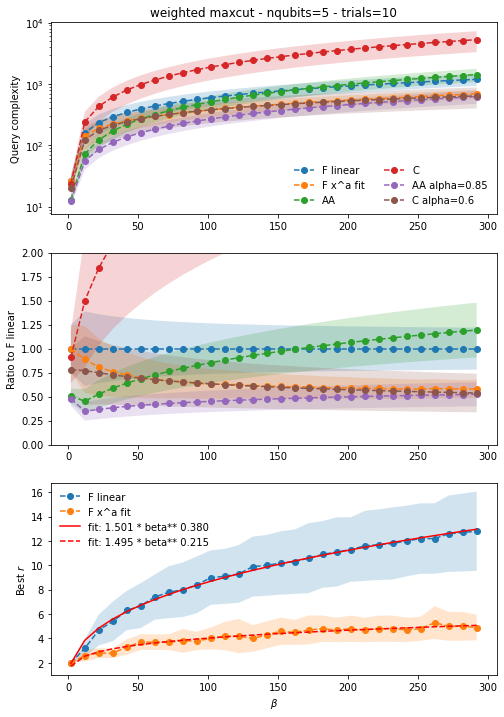

In [11]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('weighted maxcut - nqubits=%d - trials=%d' % (nqubits, ntrials))
plot_band(axs[0], beta_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], beta_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], beta_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], beta_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], beta_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], beta_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], beta_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], beta_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], beta_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'$\beta$')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$')
plot_band(axs[2], beta_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[2], beta_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

def func(x, a, b):
    #return a * np.log(np.abs(b) * x) + c
    return a * x ** b

popt, pcov = curve_fit(func, beta_range, np.mean(bestr, axis=1))
axs[2].plot(beta_range, func(beta_range, *popt), 'r-',
        label='fit: %5.3f * beta** %5.3f' % tuple(popt))

popt, pcov = curve_fit(func, beta_range, np.mean(bestr_opt, axis=1))
axs[2].plot(beta_range, func(beta_range, *popt), 'r--',
        label='fit: %5.3f * beta** %5.3f' % tuple(popt))
axs[2].legend(loc='upper left', frameon=False)

plt.savefig('weighted_maxcut_nqubits_%d.png' % (nqubits), bbox_inches='tight')

In [ ]:
# plot
xx = np.linspace(0,1,50)
for ii, beta in enumerate(beta_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')

## Example II

In [ ]:
# setup
np.random.seed(0)
ntrials = 1
beta = 200
npol = 1

def myschedule(t, params):
    return t**params[0]


nqubits_range = range(2, 10)
r_range = range(2, 45) 
alpha_c = 0.6
alpha_ampl = 0.85
qref = np.zeros(shape=(len(nqubits_range),ntrials))
qampl = np.zeros(shape=(len(nqubits_range),ntrials))
qampl_alpha = np.zeros(shape=(len(nqubits_range),ntrials))
qc = np.zeros(shape=(len(nqubits_range),ntrials))
qc_alpha = np.zeros(shape=(len(nqubits_range),ntrials))
bestr = np.zeros(shape=(len(nqubits_range), ntrials))
bestr_opt = np.zeros(shape=(len(nqubits_range), ntrials))
qopt = np.zeros(shape=(len(nqubits_range),ntrials))
parameters = np.zeros(shape=(len(nqubits_range), ntrials, npol))

    
for ii, nqubits in enumerate(nqubits_range):

    for nt in range(ntrials):
        print(f'trial={nt} nqubits={nqubits}')
        model = FragmentedQuITE(nqubits, weighted_maxcut(nqubits, norm=40.0, 
                                random_graph=True), Qu)

        qampl[ii][nt] =  model.Qampl(beta)
        qampl_alpha[ii][nt] = model.Qampl(beta, alpha=alpha_ampl)
        qc[ii][nt] = model.Q(beta)
        qc_alpha[ii][nt] = model.Q(beta, alpha=alpha_c)
        
        values = []
        for r in r_range:           
            reference = model.Qfrac_linear(r, beta)
            values.append(reference)
            print(f'trial={nt}, nqubits={nqubits}, beta={beta}, r={r}, reference={reference}')
        
        qref[ii][nt] = np.min(values)
        bestr[ii][nt] = r_range[np.argmin(values)]
        if bestr[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

        values2 = []
        params2 = []
        for r in r_range:           
            initial_guess = np.array([1.0])
            result = model.minimize(myschedule, initial_parameters=initial_guess, 
                                    r=r, b=beta,
                                    method='L-BFGS-B', bounds=[[1e-3,1e3]])
            if result.success == False:
                print(result)
                continue
            values2.append(result.fun)
            params2.append(result.x)
            print(f'trial={nt}, nqubits={nqubits}, beta={beta}, r={r}, opt result={result.fun}, param={result.x} success={result.success}')
            
        qopt[ii][nt] = np.min(values2)
        bestr_opt[ii][nt] = r_range[np.argmin(values2)]
        parameters[ii][nt] = params2[np.argmin(values2)]
        if bestr_opt[ii][nt] == r_range[-1]:
            raise RuntimeError('Increase r_range max value.')

In [ ]:
def plot_band(axs, x, cv, std, label=None):
    axs.plot(x, cv, 'o--',label=label)
    axs.fill_between(x, cv-std, cv+std, alpha=0.2)
    
fig, axs = plt.subplots(3, figsize=(8,12))
axs[0].set_title('weighted maxcut - beta=%d - trials=%d' % (beta, ntrials))
plot_band(axs[0], nqubits_range, np.mean(qref, axis=1), np.std(qref, axis=1), label='F linear')
plot_band(axs[0], nqubits_range, np.nanmean(qopt, axis=1), np.nanstd(qopt, axis=1), label='F x^a fit')
plot_band(axs[0], nqubits_range, np.mean(qampl, axis=1), np.std(qampl, axis=1), label='AA')
plot_band(axs[0], nqubits_range, np.mean(qc, axis=1), np.std(qc, axis=1), label='C')

plot_band(axs[0], nqubits_range, np.mean(qampl_alpha, axis=1), np.std(qampl_alpha, axis=1), label=f'AA alpha={alpha_ampl}')
plot_band(axs[0], nqubits_range, np.mean(qc_alpha, axis=1), np.std(qc_alpha, axis=1), label=f'C alpha={alpha_c}')

axs[0].set_yscale('log')
axs[0].legend(frameon=False, ncol=2)
axs[0].set_ylabel('Query complexity')

plot_band(axs[1], nqubits_range, np.mean(qref, axis=1)/np.mean(qref, axis=1), np.std(qref, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.nanmean(qopt, axis=1)/np.mean(qref, axis=1), np.nanstd(qopt, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], nqubits_range, np.mean(qampl, axis=1)/np.mean(qref, axis=1), np.std(qampl, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.mean(qc, axis=1)/np.mean(qref, axis=1), np.std(qc, axis=1)/np.mean(qref, axis=1))

plot_band(axs[1], nqubits_range, np.mean(qampl_alpha, axis=1)/np.mean(qref, axis=1), np.std(qampl_alpha, axis=1)/np.mean(qref, axis=1))
plot_band(axs[1], nqubits_range, np.mean(qc_alpha, axis=1)/np.mean(qref, axis=1), np.std(qc_alpha, axis=1)/np.mean(qref, axis=1))

axs[1].set_ylim([0,2])
axs[2].set_xlabel(r'nqubits')
axs[1].set_ylabel('Ratio to F linear');

axs[2].set_ylabel('Best $r$')
plot_band(axs[2], nqubits_range, np.mean(bestr, axis=1), np.std(bestr, axis=1), label='F linear')
plot_band(axs[2], nqubits_range, np.mean(bestr_opt, axis=1), np.std(bestr_opt, axis=1), 'F x^a fit')

plt.savefig('weighted_maxcut_beta_%d.png' % (beta), bbox_inches='tight')

In [ ]:
# plot
xx = np.linspace(0,1,50)
for ii, nqubits in enumerate(nqubits_range):
    plt.figure()
    plt.title('Polynomial degree %d\nMaxCUT - qubits=%d - beta=%.1f - r=%d' % (len(initial_guess)+1,nqubits, beta, r))
    for jj in range(parameters.shape[1]):
        r = int(bestr[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr, xr, 'o--', color='blue', label=f'r={r}')        
        
        r = int(bestr_opt[ii][jj])
        xr = np.array(range(1,r+1))/r      
        plt.plot(xr,[myschedule(ixr, parameters[ii][jj]) for ixr in xr], 'o', color='orange', label=f'r={r}')
        plt.plot(xx,[myschedule(ixr, parameters[ii][jj]) for ixr in xx], '--', color='orange')
        print('x=',xr,'DeltaBeta=',[myschedule(ixr, parameters[ii][jj]) for ixr in xr],'\n')
        
    plt.xlabel('x = step/r')